# Model Development - Part II
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the changes made to the selected architecture from `Model Improvement - Part I`.
- The positive changes are combined to obtain the best performing model.
- GPU can be used.
- Training durations can be compared as training is performed on the same GPU.

- Following are the changes examined -
    - Section One -
        - Multitask learning (with 4 methods of loss calculation).
        - Task specific layers. 
        - Normalization method for numerical values.
    - Section Two -
        - Activation function.
        - Pooling method.
        - Dropout.
        - Batch normalization.
        - Attention mechanism.
        - Weight Initialization.
    - Section Three - 
        - Optimization algorithm.
        - Momentum.
        - Weight decay or L2 regularization.
        - Learning rate decay.

The sections are as follows -
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Preparation](#data_preparation)
- [Training Parameters](#training_parameters)
- [Model Parameters](#model_parameters)
- [Overview](#overview)
- [Section I](#section_one)
- [Section II](#section_two)
- [Section III](#section_three)
- [Final Values](#final)
- [Save File](#save_file)

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Loading the IEMOCAP Spectrograms, IEMOCAP Meta, network module, visualization module, and helper module into the session storage (for use in Colab).
- Additionally installing `torchmetrics`.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Spectrograms.zip' 'IEMOCAP Spectrograms.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'IEMOCAP Spectrograms.zip'
!unzip 'IEMOCAP Meta.zip'
!unzip 'network.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

!pip install torchmetrics

Streaming output truncated to the last 5000 lines.
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses03M_impro07_M001_split1/Ses03M_impro07_M001_split1_aug6.png  
   creating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug3.png  
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug5.png  
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug1.png  
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug6.png  
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug2.png  
  inflating: IEMOCAP Spectrograms/Train/Happiness/Ses05F_script01_3_F017_split1/Ses05F_script01_3_F017_split1_aug4.png  
   creating: IEMOCAP Spectr

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the network module.
> `batch` - code for batch-related operations.
<br>
> `train` - code for training the network.

In [2]:
import sys
sys.path.append('./network')

from network.batch import create_batches, get_augmentations
from network.train import get_simple_model, train_simple_network, get_complex_model, train_complex_network

#### Step 2:
- Importing the required functions from the visualization module.
    > `explanation` - code for conducting explanatory visualizations.

In [50]:
sys.path.append('./visualization')

from visualization.explanation import compare_complex, compare_hybrid, plot_complex

#### Step 3:
Importing the required functions from the helper module.
> `common` - code for general-purpose functions common among all modules.<br>
> `network` - code for general-purpose functions of network module.

In [4]:
from helper.common import save_data
from helper.network import load_data, get_emotion_num, get_classification_metric, get_regression_metric, get_criterion

<a id='data_preparation'></a>
## Data Preparation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Loading `split_data`, `class_data`, `stats`, and selected architecture.

In [5]:
root = './IEMOCAP Spectrograms'
meta_root = './IEMOCAP Meta'
roots = (root, meta_root)
name = 'iemocap'

split_data = load_data(meta_root, 'Split')
class_data = load_data(meta_root, 'Class')
stats = load_data(meta_root, 'Statistics')

ARCH = load_data(meta_root, 'Selected')

#### Step 2:
- Obtaining the number of outputs for each task.
- Defining the type of each task.

In [6]:
num_outputs = [get_emotion_num(name, class_data), 2, 1, 1, 1]

tasks = ('Emotions', 'Genders', 'Valence', 'Activation', 'Dominance')
task_type = ('classification', 'classification', 'regression', 'regression', 'regression')

for i, output in enumerate(num_outputs):
    print(f'{tasks[i]}: {output}')

Emotions: 8
Genders: 2
Valence: 1
Activation: 1
Dominance: 1


#### Step 3:
Obtaining the names of files in the train and valid sets. For this notebook, only original samples are considered for faster training.
> `num_augs` - number of augmentations to include. 1 represents the unaugmented spectrograms.

In [ ]:
train_data_aug = get_augmentations(split_data['train'], num_augs = [1])
valid_data_aug = get_augmentations(split_data['valid'], num_augs = [1])

#### Step 4:
- Creating train and valid batches. The data only includes the names of the files in the batches, not the inputs or labels.
> `batch_size` - number of batches. Kept as **64** for this notebook.<br>
> `shuffled_train` - shuffled train data to fill missing entries in the last batch, if required.<br>
> `shuffled_valid` - shuffled valid data to fill missing entries in the last batch, if required.

- Saving the batches for use during training.

In [ ]:
batch_size = 64

train_batches, shuffled_train = create_batches(train_data_aug, batch_size)
valid_batches, shuffled_valid = create_batches(valid_data_aug, batch_size)

data_batches = (train_batches, valid_batches)
shuffled_data = (shuffled_train, shuffled_valid)

batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

<a id='training_parameters'></a>
## Training Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining training parameters. Metrics selected are -
> - **Accuracy** - computes ratio of number of samples correctly classified to total number of samples.<br>
> - **F1 Score** - harmonic mean of precision and recall. Here, ${\beta}$ = 1 indicates equal weightage to precision and recall.<br>
> - **Root Mean Squared Error** - measures the root of the average squared difference between the estimated values and the actual value.

- Additionally, `average_type` is the method of averaging classification metric results. The chosen method is -
> **weighted** - calculates the metric for each class separately, and averages the metrics across classes, weighting each class by its support (`tp` + `fn`). This is good for an imbalanced dataset.<br>

In [7]:
metrics = get_classification_metric('weighted', num_emotion = num_outputs[0], num_gender = num_outputs[1])
metrics.extend(get_regression_metric(num_metrics = 3))

#### Step 2:
Defining loss functions (`criterion`)- 
> - **Categorical** - loss function for categorical labels is **Negative Log-likelihood Loss**. Since predictions are obtained through **Log Softmax**, they both combine to form the **Categorical Cross Entropy Loss**.<br>
> - **Numerical** - loss function for numerical labels is **Root Mean Squared Error Loss**. Predictions are obtained as activation function outputs.

In [8]:
criterion = get_criterion(task_type)

#### Step 3:
Packing the training parameters.
> **Min-Max Scaler** - each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$. <br>
> **Epochs** - training for 10 epochs.

In [13]:
scaling_type = 'min-max'
epochs = 10

torch_params = {'criterion': criterion, 'metrics': metrics}
other_params = {'scaling type': scaling_type, 'task type': task_type, 'epochs': epochs, 'batch size': batch_size}

<a id='model_parameters'></a>
## Model Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Obtaining the input normalization transform. Each channel is transformed using $\frac{\text{channel input} \text{ - } \text{channel mean}}{\text{channel std}}$.
> `color_map` - color map for images.<br>
> `channel_mean` - mean for each channel.<br>
> `channel_std` - standard deviation for each channel.

In [14]:
channel_mean, channel_std, color_map = stats['channel mean'], stats['channel std'], stats['color map']

transforms = [channel_mean, channel_std, color_map]
print(f'Channel Mean - {transforms[0]} | Channel Std - {transforms[1]} | Color Map - {transforms[2]}')

Channel Mean - [0.2746834032590987] | Channel Std - [0.17490942513599714] | Color Map - L


<a id='overview'></a>
## Overview
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Data compared in analyzing performance is as follows - 

| Category | Training Loss | Validation Loss | Accuracy | F1 Score | RMSE
| :-: | :-: | :-: | :-: | :-: | :-: |
| Overall | &#10004; | &#10004; | &#10006; | &#10006; | &#10006; |
| Emotion | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| Gender | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| Valence | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |
| Activation | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |
| Dominance | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |

- `get_complex_model` performs the following -
    > - Assignment of input image size.<br>
    > - Instantiation of the model.<br>
    > - Instantiation of the optimizer.
    
- `train_complex_network` performs training and validation of the model -
> - In each epoch, batch is loaded and transformations are applied.
> - Before normalization, each image is resized and converted to a tensor.
> - Numerical predictions and labels are scaled back to original values before being fed to their corresponding metric.

- Following are the parameters which will be changed -
> `layer_params` - parameters for the layers of the network.<br>
> `optim_params` - parameters for the optimizer.<br>
> `multi_params` - parameters for the multitask network.

- `plotting_data` - stores results of training for all models.

In [15]:
plotting_data = {}

#### Step 1:
Training the `initial` architecture.

In [ ]:
simple_torch_params = {'criterion': criterion[0], 'metrics': metrics[:2]}
simple_other_params = {'epochs': epochs, 'batch size': batch_size}

model_params = get_simple_model(ARCH, transforms, num_outputs[0])
plotting_data['initial'] = train_simple_network(roots, model_params, simple_torch_params, simple_other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

#### Step 2:
Assigning the complex-model's input and output size.

In [16]:
ARCH['output'] = num_outputs
ARCH['convolutional'][0]['input'] = 1 if color_map == 'L' else 3

<a id='section_one'></a>
## Section I
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- In this section, following changes are examined -
    - Multitask learning (with 4 methods of loss calculation).
    - Task specific layers. 
    - Normalization method for numerical values.

- `layer_params` and `optim_params` are constant for this section. 


| Layer Parameters | Optimizer Parameters |
| :-: | :-: |
| Activation - ReLU | Learning Rate - 0.01 |
| Pooling - MaxPool | Type - SGD | 
| Dropout - 0 | Momentum - 0 | 
| Batch Norm - False | Weight Decay - 0 |
| Attention - None | Scheduler - None |
| Weight Init - False |

In [ ]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0, 'batch norm': False, 
    'attention': None, 'weight init': False
               }
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': None}

multitask_params = {'loss type': None, 'loss weights': None, 'task layers': None}

#### Multitask Learning (`loss_type` - sum):
For `multitask_params` -
> - Overall loss is the sum of the individual losses of the tasks.<br>
> - No loss weights required.<br>
> - No task-specific layers.

In [ ]:
multitask_params = {'loss type': 'sum', 'loss weights': None, 'task layers': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['multi sum'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Single Task | Training Duration = 797.66 sec | Average Duration = 79.77 sec
Model Multi Sum | Training Duration = 806.90 sec | Average Duration = 80.69 sec


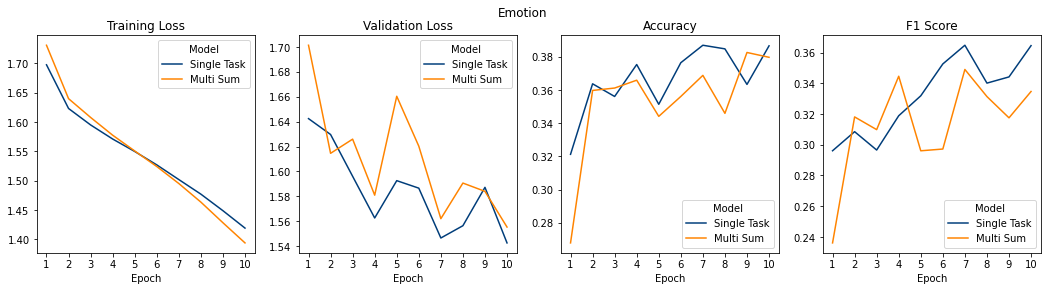

In [ ]:
compare_hybrid(plotting_data['initial'], 'Single Task', plotting_data['multi sum'], 'Multi Sum', epochs)

#### Comparison (Single Task and Multi Sum):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| Single Task | - | - | &#10004; | &#10004; |
| Multi Sum | - | - | &#10006; | &#10006; |

> **Winner** - Single Task

#### Multitask Learning (`loss_type` - param):
For `multitask_params` -
> - Overall loss is the weighted sum of all losses. Weights are learnt by the network. This is an implementation to an approach developed in -<br>
    >> Kendall, A., Gal, Y. and Cipolla, R., 2022. Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics. [online] pp.7482-7491. Available at: <https://arxiv.org/pdf/1705.07115.pdf>.<br>
> - No loss weights required.<br>
> - No task-specific layers.

In [ ]:
multitask_params = {'loss type': 'param', 'loss weights': None, 'task layers': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['multi param'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Single Task | Training Duration = 797.66 sec | Average Duration = 79.77 sec
Model Multi Param | Training Duration = 802.40 sec | Average Duration = 80.24 sec


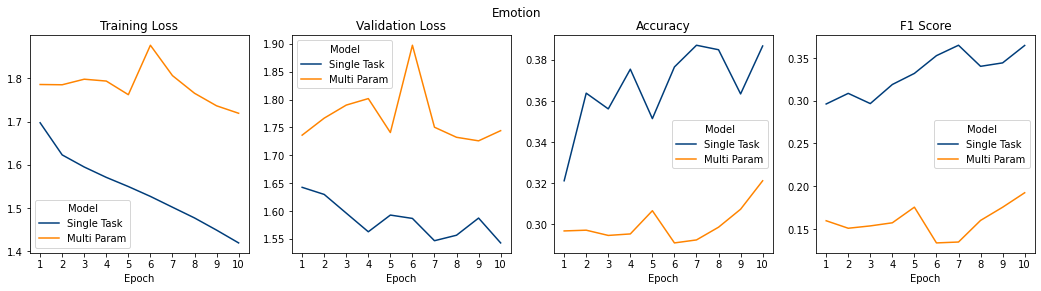

In [ ]:
compare_hybrid(plotting_data['initial'], 'Single Task', plotting_data['multi param'], 'Multi Param', epochs)

#### Comparison (Single Task and Multi Param):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| Single Task | - | - | &#10004; | &#10004; |
| Multi Param | - | - | &#10006; | &#10006; |

> **Winner** - Single Task

#### Multitask Learning (`loss_type` - weighted):
For `multitask_params` -
> - Overall loss is the sum of emotion of loss and weighted sum of all losses given by -<br>
>> $C_{overall} = C_{emotion}\text{ + }\sum_{i=1}^{k} \lambda_iC_{i}$<br><br>
>>    - $k$ is the number of auxiliary tasks.
>>    - $\lambda_i$ is the weight of each auxiliary task.
>>    - $C_i$ is the cost of each auxiliary task.
>>    - $\sum_{i=1}^{k} \lambda_i = 1$
> - Loss weights are defined as follows -<br>
>>    - Gender - 0.2
>>    - Valence - 0.3
>>    - Activation - 0.3
>>    - Dominance - 0.2
> - No task-specific layers.

In [ ]:
multitask_params = {'loss type': 'weighted', 'loss weights': [0.2, 0.3, 0.3, 0.2], 'task layers': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['multi weighted'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Single Task | Training Duration = 797.66 sec | Average Duration = 79.77 sec
Model Multi Weighted | Training Duration = 768.90 sec | Average Duration = 76.89 sec


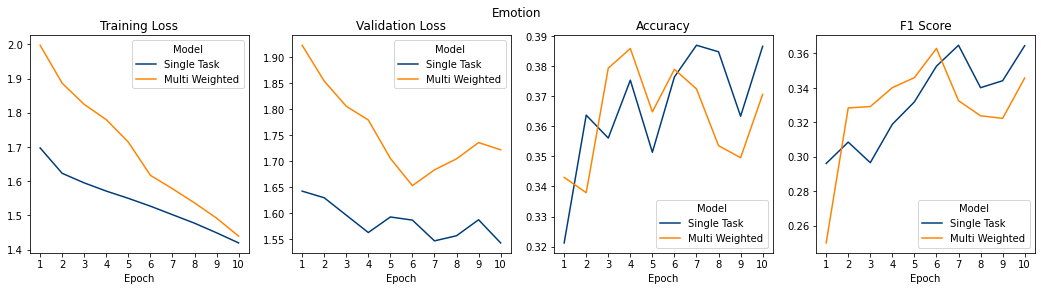

In [ ]:
compare_hybrid(plotting_data['initial'], 'Single Task', plotting_data['multi weighted'], 'Multi Weighted', epochs)

#### Comparison (Single Task and Multi Weighted):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| Single Task | - | - | &#10004; | &#10004; |
| Multi Weighted | - | - | &#10006; | &#10006; |

> **Winner** - Single Task

#### Multitask Learning (`loss_type` - weighted param):
For `multitask_params` -
> - Overall loss is the sum of emotion of loss and weighted sum of all losses given by -<br>
>> $C_{overall} = C_{emotion}\text{ + }\sum_{i=1}^{k} \lambda_iC_{i}$<br><br>
>>    - $k$ is the number of auxiliary tasks.
>>    - $\lambda_i$ is the weight of each auxiliary task.
>>    - $C_i$ is the cost of each auxiliary task.
>>    - Weights are passed through a softmax function so that  $\sum_{i=1}^{k} \lambda_i = 1$.
> - No loss weights are required. They are learnt by the network.
> - No task-specific layers.

In [ ]:
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['multi weighted param'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Single Task | Training Duration = 797.66 sec | Average Duration = 79.77 sec
Model Multi WP | Training Duration = 767.49 sec | Average Duration = 76.75 sec


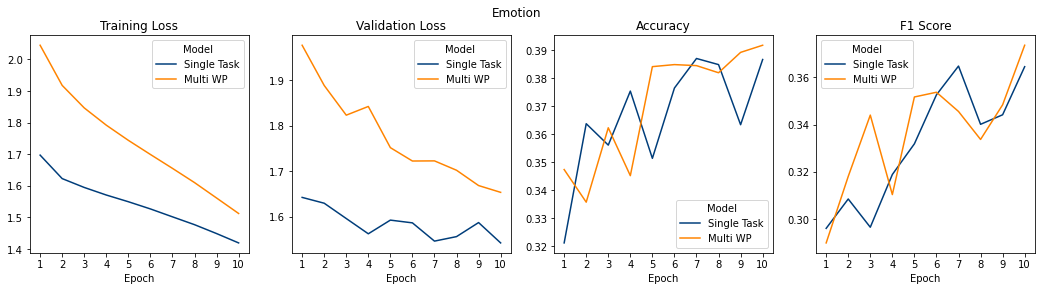

In [ ]:
compare_hybrid(plotting_data['initial'], 'Single Task', plotting_data['multi weighted param'], 'Multi WP', epochs)

#### Comparison (Single Task and Multi WP):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| Single Task | - | - | &#10006; | &#10006; |
| Multi WP | - | - | &#10004; | &#10004; |

> **Winner** - Multi WP

#### Task Specific Layers:
For `multitask_params` -
> - Overall loss is of type **weighted param**.
> - No loss weights are required. They are learnt by the network.
> - Size of specific layers are as follows - 
>> - Emotion - 1024
>> - Gender - 256
>> - Valence - 256
>> - Activation - 256
>> - Dominance - 256

In [ ]:
task_layers = (1024, 256, 256, 256, 256)
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': task_layers}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['task specific'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Multi TS | Training Duration = 776.53 sec | Average Duration = 77.65 sec
Model Multi WP | Training Duration = 767.49 sec | Average Duration = 76.75 sec


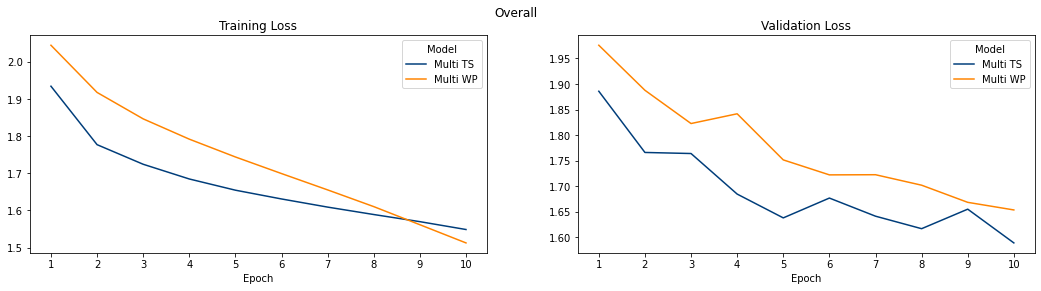

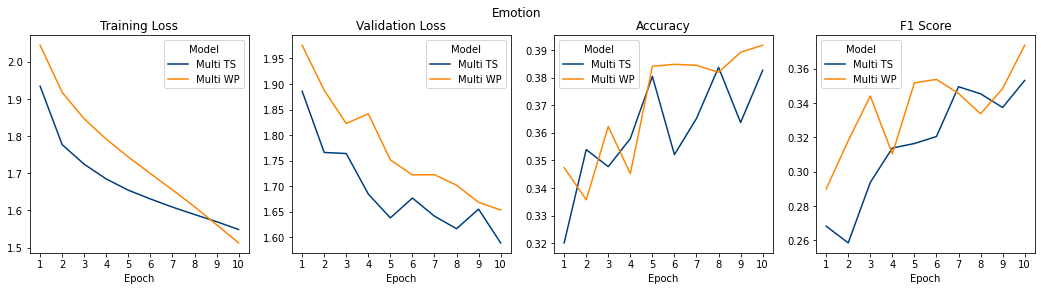

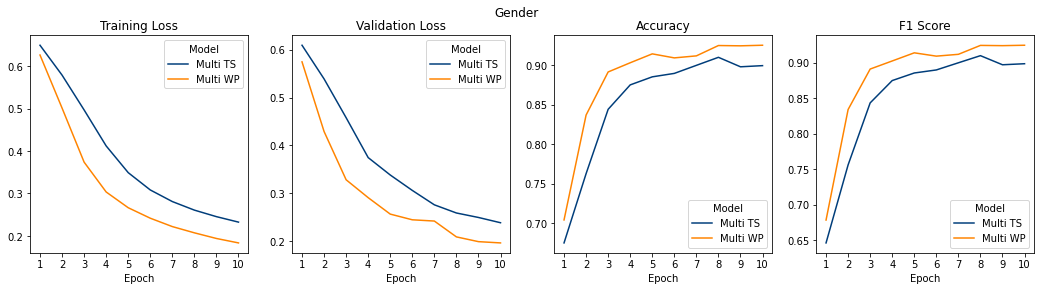

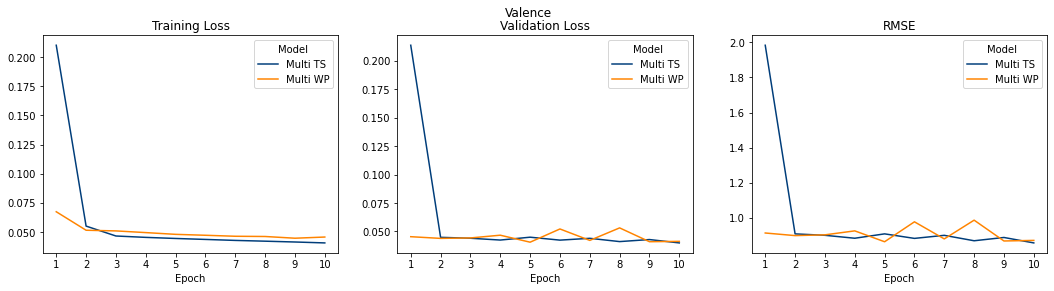

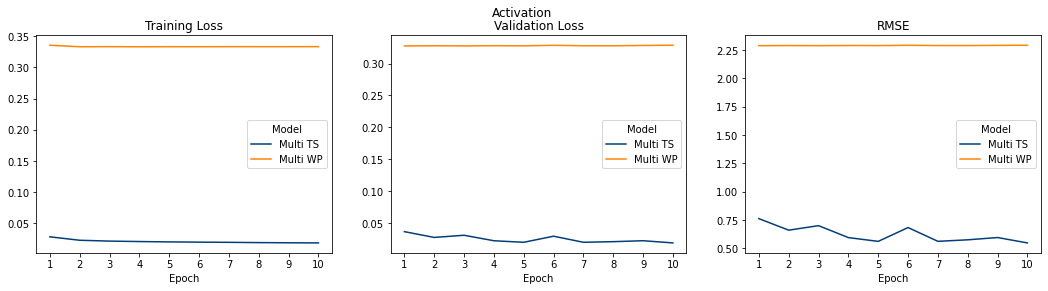

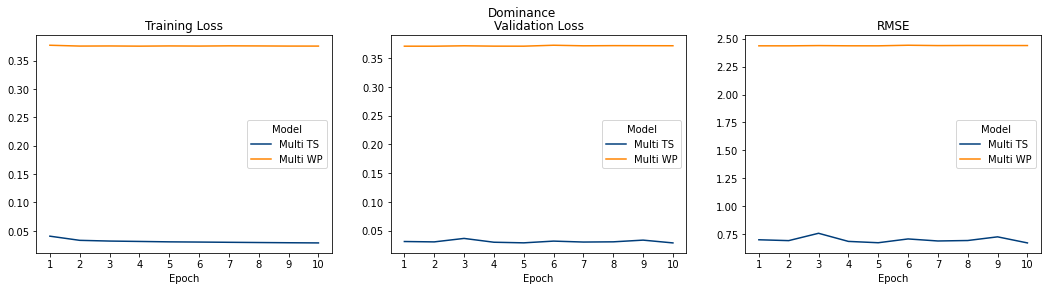

In [ ]:
compare_complex(plotting_data['task specific'], 'Multi TS', plotting_data['multi weighted param'], 'Multi WP', epochs)

#### Comparison (Multi TS and Multi WP):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Multi TS | - | &#10006; | &#10006; | &#10004; | &#10004; | &#10004; |
| Multi WP | - | &#10004; | &#10004; | &#10004; | &#10006; | &#10006; |

> **Winner** - Multi WP<br>
> **Insight** - layer size can be tuned as a hyperparameter.

#### Normalization Type (Standard Scaler)
2 scaling methods are tested - 
> **Min-Max Scaler** - each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$. This has been used up till now.<br>
> **Standard Scaler** - each value is transformed using $\frac{\text{x} \text{ - } \text{mean}}{\text{std}}$.

In [ ]:
other_params['scaling type'] = 'standard'
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['standard scaler'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Standard | Training Duration = 778.76 sec | Average Duration = 77.88 sec
Model Min-Max | Training Duration = 767.49 sec | Average Duration = 76.75 sec


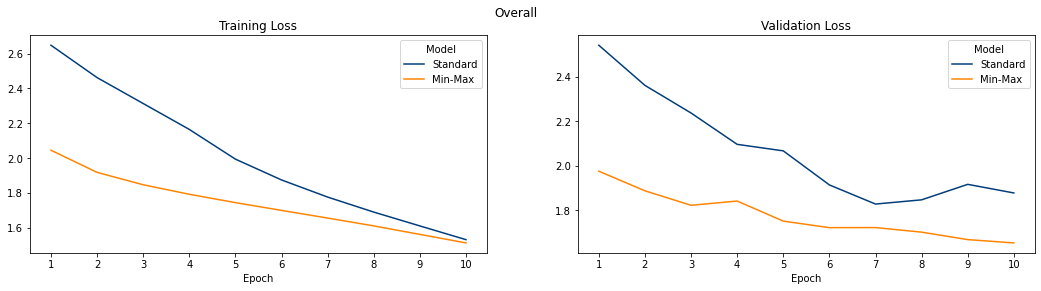

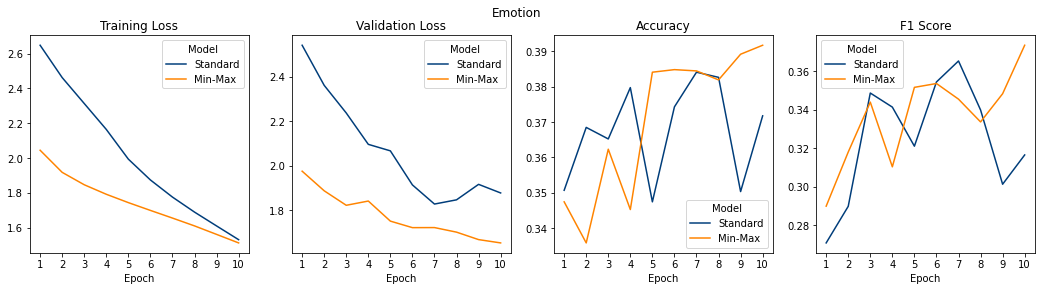

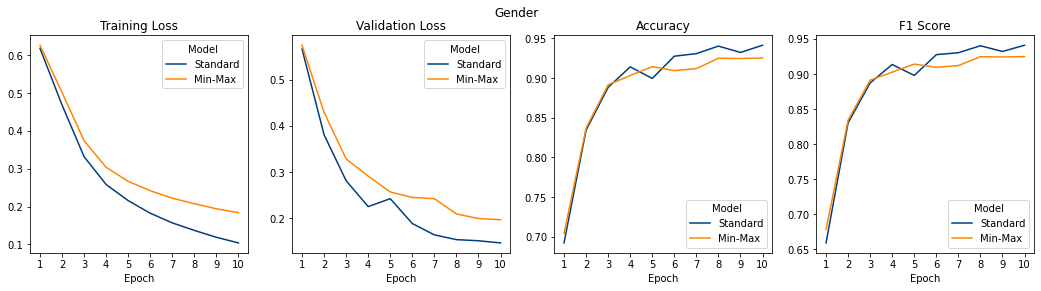

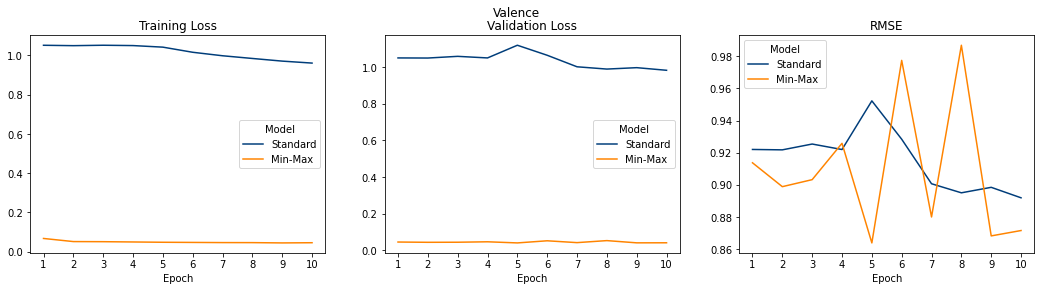

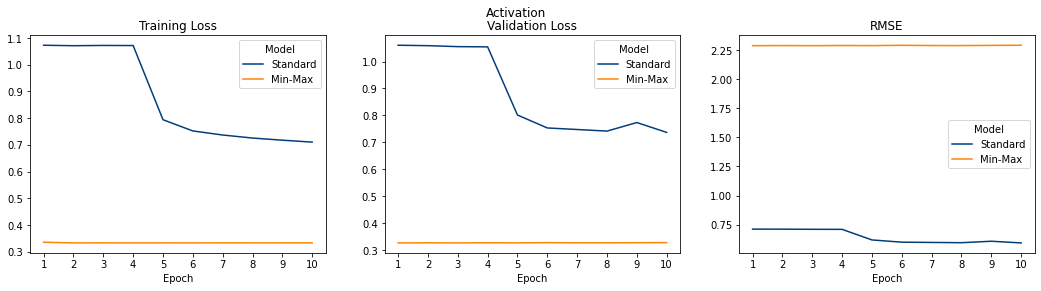

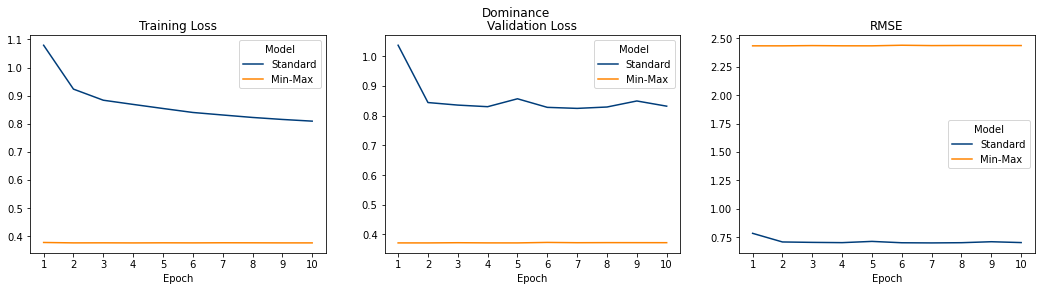

In [ ]:
compare_complex(plotting_data['standard scaler'], 'Standard', plotting_data['multi weighted param'], 'Min-Max', epochs)

#### Comparison (Standard and Min-Max):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Standard | &#10006; | &#10006; | &#10004; | &#10006; | &#10004; | &#10004; |
| Min-Max | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; | &#10006; |

> **Winner** - Min-Max<br>
> **Insight** - standard scaling may be considered.

In [ ]:
other_params['scaling type'] = 'min-max'

<a id='section_two'></a>
## Section II
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- In this section, following changes are examined -
    - Activation function.
    - Pooling method.
    - Dropout.
    - Batch normalization.
    - Attention mechanism.
    - Weight initialization.

- `multitask_params` and `optim_params` are constant for this section. 


| Optimizer Parameters | Multitask Parameters |
| :-: | :-: |
| Learning Rate - 0.01 | Loss Type - weighted param
| Type - SGD | Loss Weights - None |
| Momentum - 0 | Task Layers - None | 
| Weight Decay - 0 |
| Scheduler - None |

In [17]:
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': None}
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}

layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0, 'batch norm': False, 
    'attention': None, 'weight init': False
               }

#### Activation Function (ReLU vs Leaky ReLU):
Rectified Linear Unit (Used up till now) -
> $f(x) = max(0,x)$

- It is suited for deep learning applications.
- Fewer vanishing gradient problems compared to sigmoid function.
- Only comparison (addition and multiplication) needs to be performed.

Leaky ReLU - <br>
> $f(x)=(\alpha x) \text{ if } (x<0)$<br> 
> $f(x)=(x) \text{ if } (x>=0)$<br> where $\alpha$ is a small positive slope.

- Solves the dying ReLU problem where some ReLU neurons remain inactive no matter what input is supplied. It has a small slope for negative values, so the neurons output some value instead of zero.

In [19]:
layer_params = {
    'activation': 'leaky_relu', 'pooling': 'max', 'dropout': 0, 'batch norm': False, 
    'attention': None, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['leaky relu'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model ReLU | Training Duration = 767.49 sec | Average Duration = 76.75 sec
Model Leaky ReLU | Training Duration = 818.63 sec | Average Duration = 81.86 sec


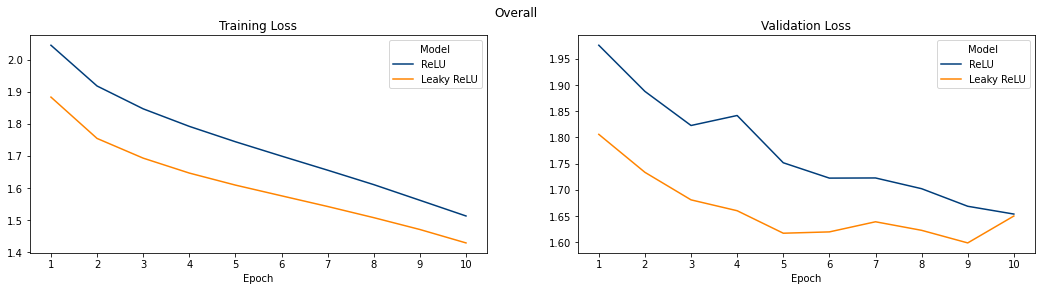

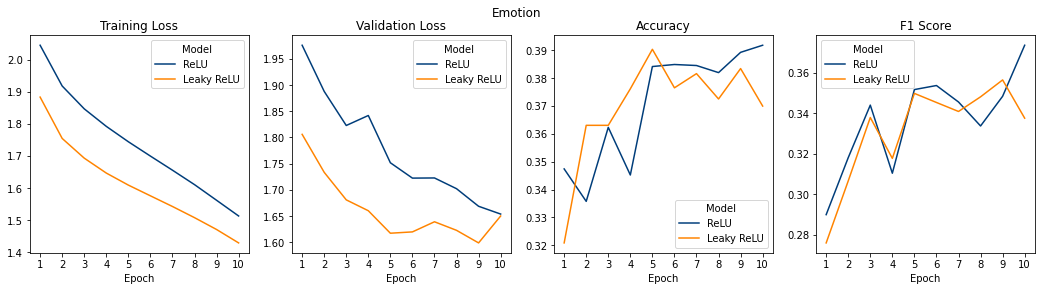

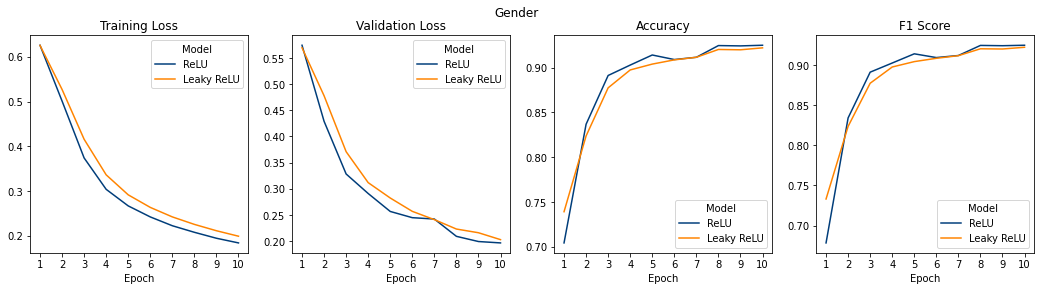

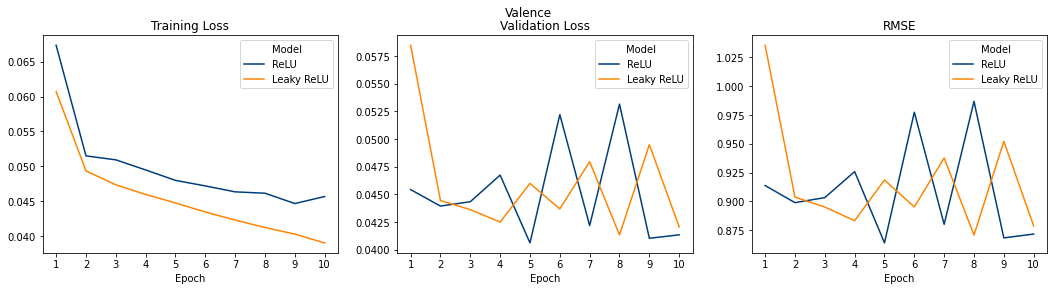

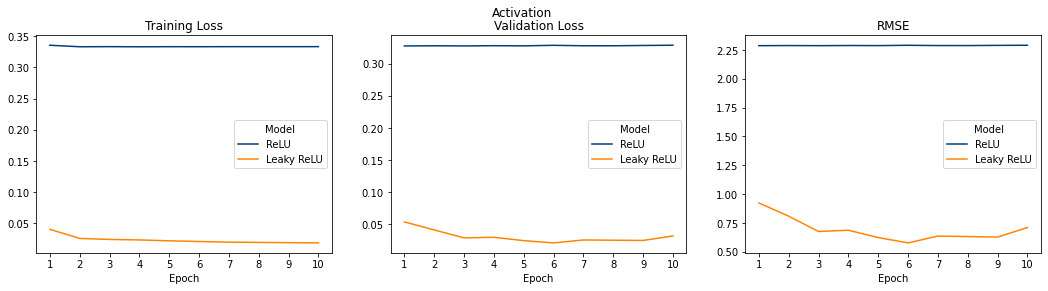

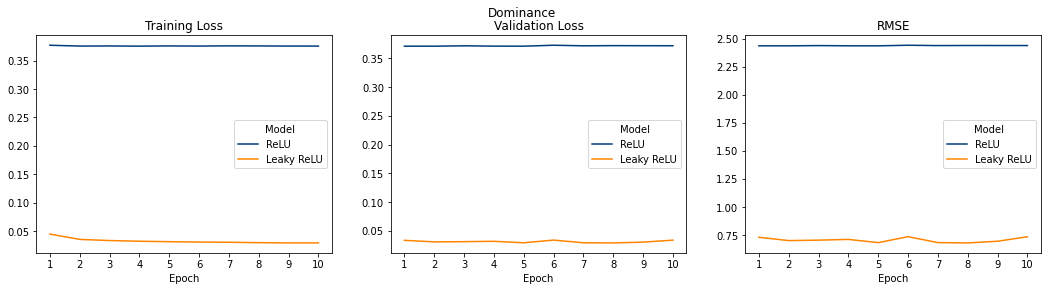

In [20]:
compare_complex(plotting_data['multi weighted param'], 'ReLU', plotting_data['leaky relu'], 'Leaky ReLU', epochs)

#### Comparison (ReLU and Leaky ReLU):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| ReLU | &#10006; | &#10004; | &#10004; | &#10004; | &#10006; | &#10006; |
| Leaky ReLU | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - ReLU<br>
> **Insight** - leaky relu may be considered.

#### Pooling Type (Max vs Average):
Max Pooling (Used up till now) - 
- Returns the maximum value from the portion of the image that is covered by the kernel.
- Identifies the sharp features through value.

Average Pooling -
- Returns the average of all values from the portion of the image that is covered by the kernel.
- Smooths out the image so sharp features may not be identified.

In [21]:
layer_params = {
    'activation': 'relu', 'pooling': 'average', 'dropout': 0, 'batch norm': False, 
    'attention': None, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['avg pool'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Max | Training Duration = 767.49 sec | Average Duration = 76.75 sec
Model Average | Training Duration = 791.26 sec | Average Duration = 79.13 sec


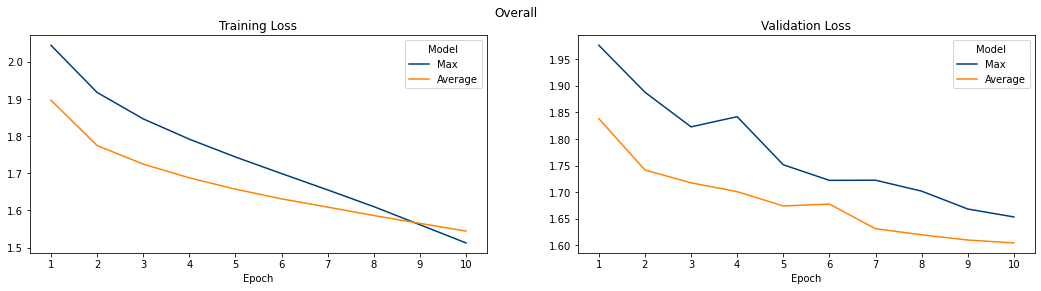

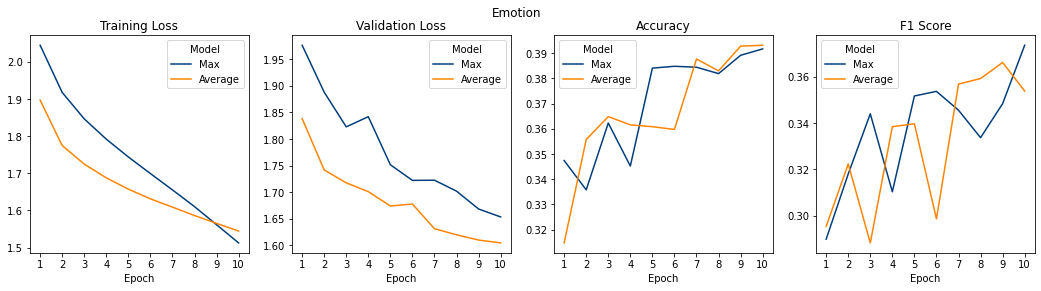

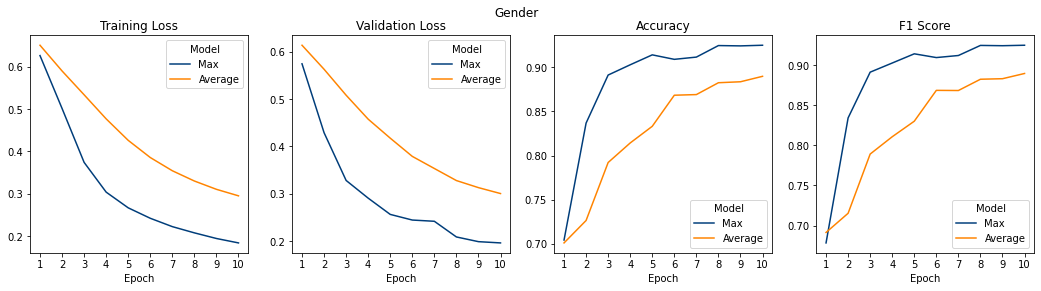

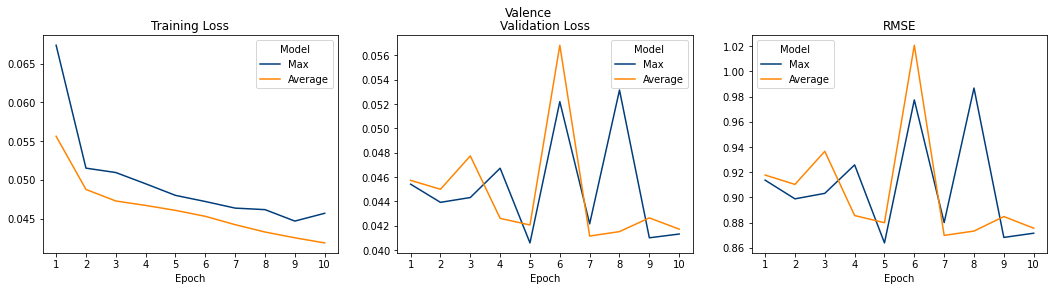

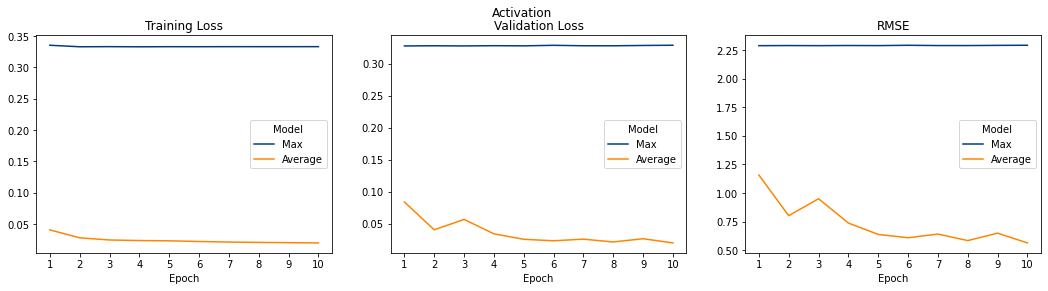

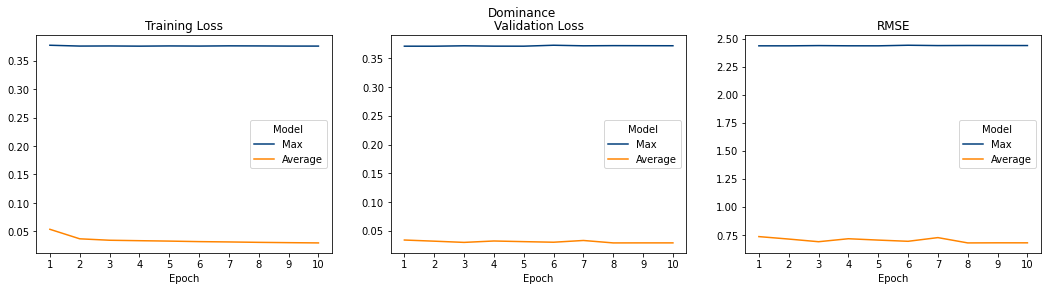

In [22]:
compare_complex(plotting_data['multi weighted param'], 'Max', plotting_data['avg pool'], 'Average', epochs)

#### Comparison (Max and Average):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Max | &#10006; | &#10006; | &#10004; | &#10004; | &#10006; | &#10006; |
| Average | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; | &#10004; |

> **Winner** - Average

#### Dropout:
- A regularization technique used to prevent a model from overfitting.
- It works by randomly ignoring some hidden neurons during training phase. These neurons are not considered for the forward and backward pass. Incoming and outgoing edges to a dropped-out neuron are also removed.
- The probability that a neuron is dropped-out is **0.50**.


In [28]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': False, 
    'attention': None, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['dropout'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model No Dropout | Training Duration = 767.49 sec | Average Duration = 76.75 sec
Model Dropout | Training Duration = 797.62 sec | Average Duration = 79.76 sec


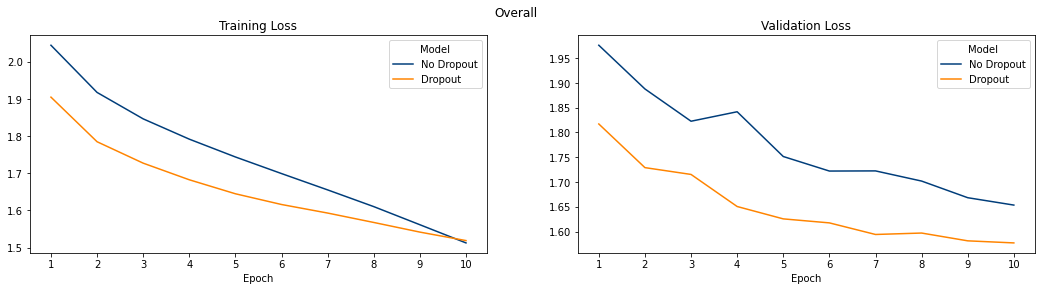

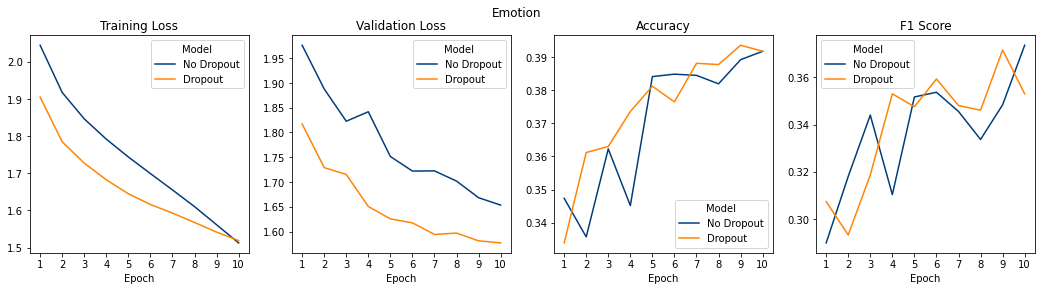

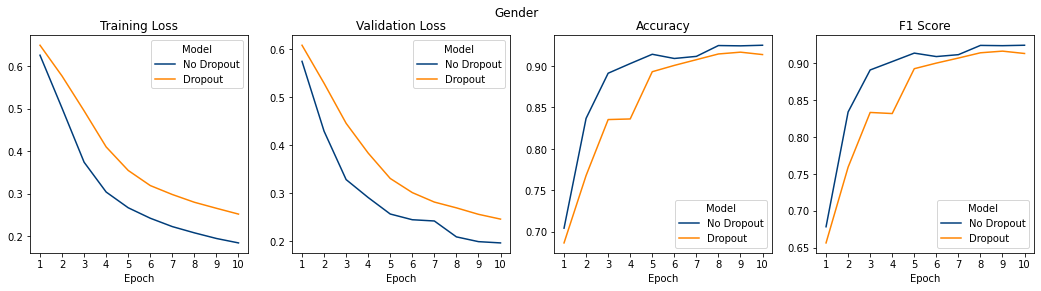

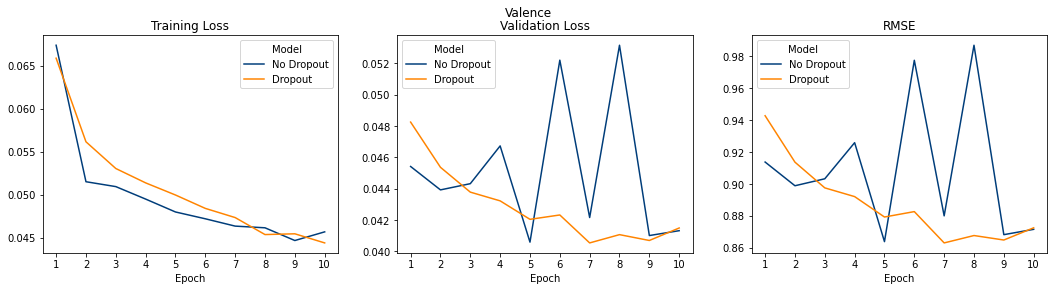

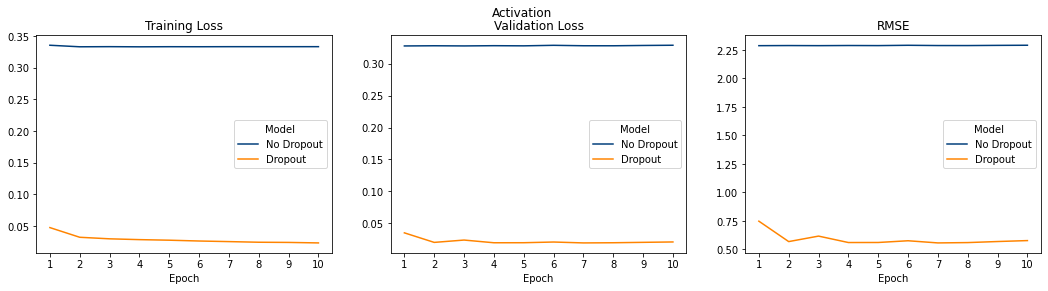

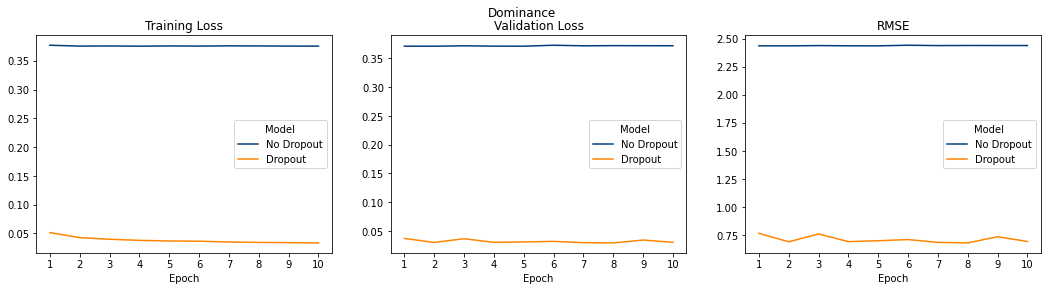

In [29]:
compare_complex(plotting_data['multi weighted param'], 'No Dropout', plotting_data['dropout'], 'Dropout', epochs)

#### Comparison (No Dropout and Dropout):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| No Dropout | &#10006; | &#10006; | &#10004; | &#10006; | &#10006; | &#10006; |
| Dropout | &#10004; | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - Dropout

#### Batch Normalization:
- It is a normalization technique performed along mini-batches instead of the full dataset.
- It serves to speed up training and use higher learning rates.
- The is defined as - 
> $z^N = \frac{z \text{ - } m_z}{s_z} . \gamma + \beta$ <br>
> where<br>
> $z^N$ is the output of batch norm layer.<br>
> $z$ is the neuron output.<br>
> $m_z$ is the mean of neuron outputs.<br>
> $s_z$ is the standard deviation of neuron outputs.
- $z^N$ is then fed to the activation function.
- The parameters $\beta$ and $\gamma$ shift the mean and standard deviation, respectively. Thus, the outputs of batch norm over a layer results in a distribution with a mean $\beta$ and a standard deviation of $\gamma$. These values are learnt during training.

In [30]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': True, 
    'attention': None, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['batch norm'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Batch Norm | Training Duration = 804.76 sec | Average Duration = 80.48 sec
Model No Batch Norm | Training Duration = 797.62 sec | Average Duration = 79.76 sec


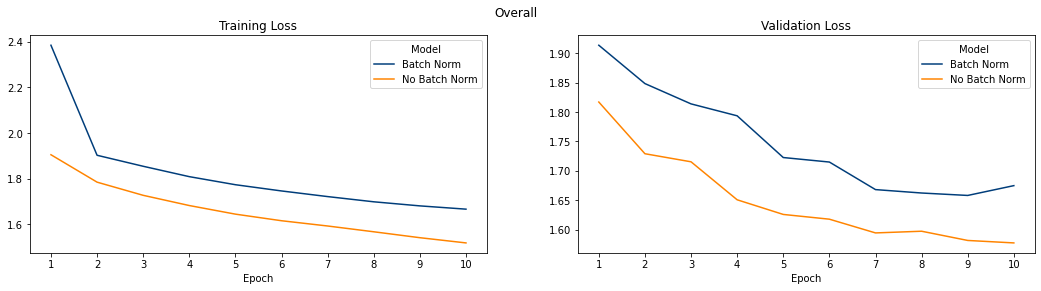

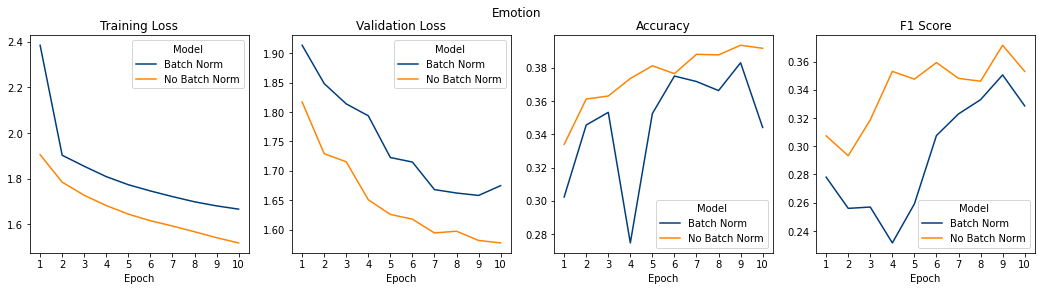

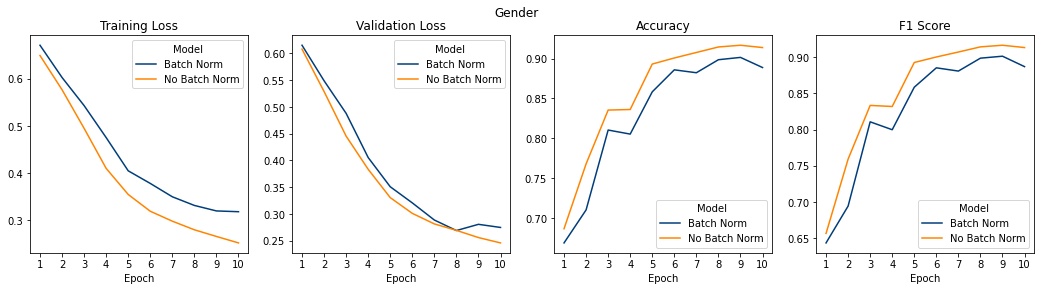

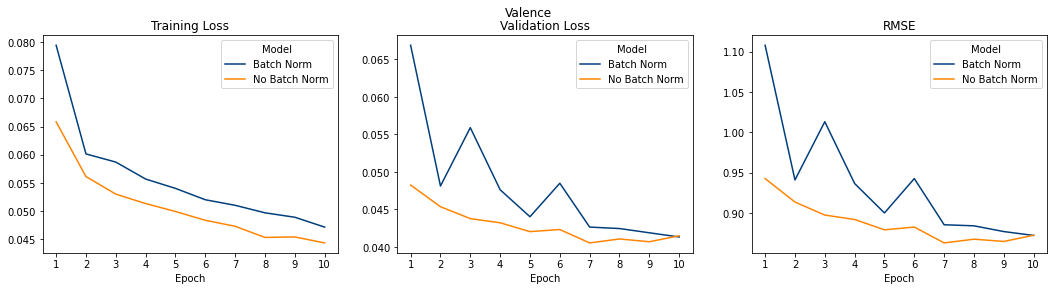

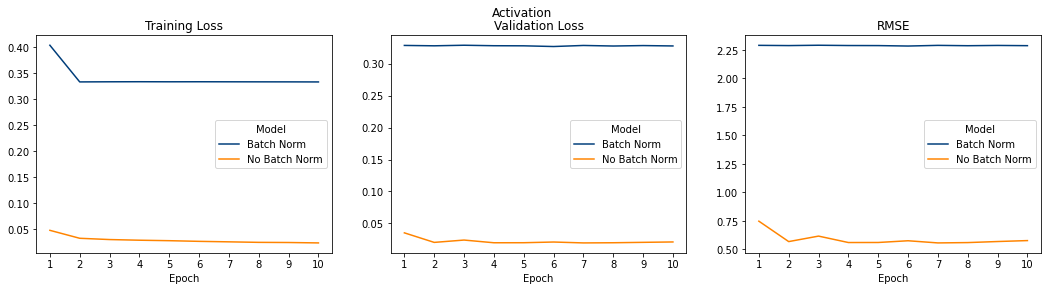

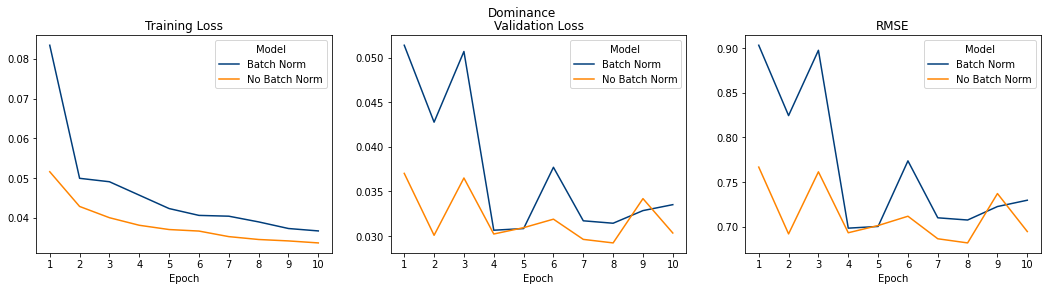

In [31]:
compare_complex(plotting_data['batch norm'], 'Batch Norm', plotting_data['dropout'], 'No Batch Norm', epochs)

#### Comparison (Batch Norm and No Batch Norm):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Batch Norm | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; |
| No Batch Norm | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - No Batch Norm

#### Attention Mechanism:

- This mechanism is developed in -
> Yang, L., Zhang, R., Li, L. and Xie, X., 2021. SimAM: A Simple, Parameter-Free Attention Module for Convolutional Neural Networks. In: 38th International Conference on Machine Learning. [online] Available at: <http://proceedings.mlr.press/v139/yang21o/yang21o.pdf>.

- It infers 3D attention weights for the feature map in a layer without adding parameters to the original networks. 
- In visual neuroscience, an active neuron may suppress the activities of surrounding neurons (spatial suppression). 
- So, the neurons displaying clear spatial suppression effects should be given importance in visual processing. 
- An energy function is proposed in which mean and variance can be calculated over all neurons and reused for all neurons on a particular channel.
> $e_t^* = \frac{4(\hat{\sigma}^2 + \lambda)}{(t - \hat{\mu})^2 + 2\hat{\sigma}^2 + 2\lambda}$<br>
where<br>
> - $\hat{\mu} = \frac{1}{M}\sum_{i=1}^{M}x_i$<br>
> - $\hat{\sigma}^2 = \frac{1}{M}\sum_{i=1}^{M}(x_i - \hat{\mu})^2$<br>
> - $\lambda = 0.0001$ is recommended.

- The lower the energy $e_t^*$ of a neuron $t$, the more distinctive it is from surrounding neurons and thus more important. Therefore, the importance of each neuron is obtained by $\frac{1}{e_t^*}$.

- The final output of the attention mechanism becomes -
> $\tilde{X} = sigmoid(\frac{1}{E})\cdot{X}$<br>
where<br>
> - $E$ groups all $e_t^*$ and $sigmoid$ restricts too large value in $E$. 
> - It will not influence the relative importance of each neuron because $sigmoid$ is a monotonic function.

In [32]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['attention'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Attention | Training Duration = 798.35 sec | Average Duration = 79.83 sec
Model No Attention | Training Duration = 797.62 sec | Average Duration = 79.76 sec


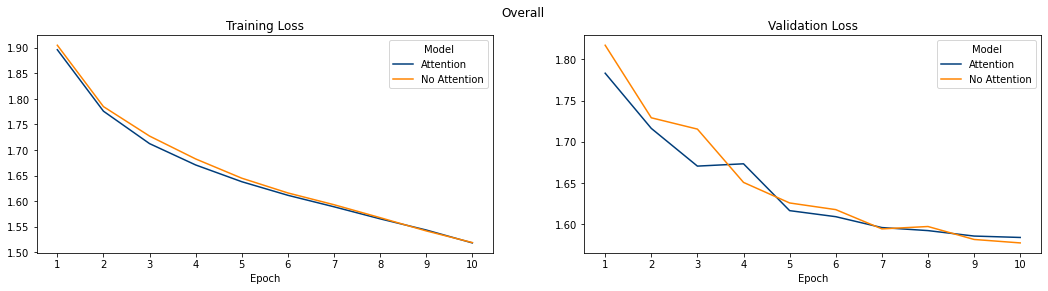

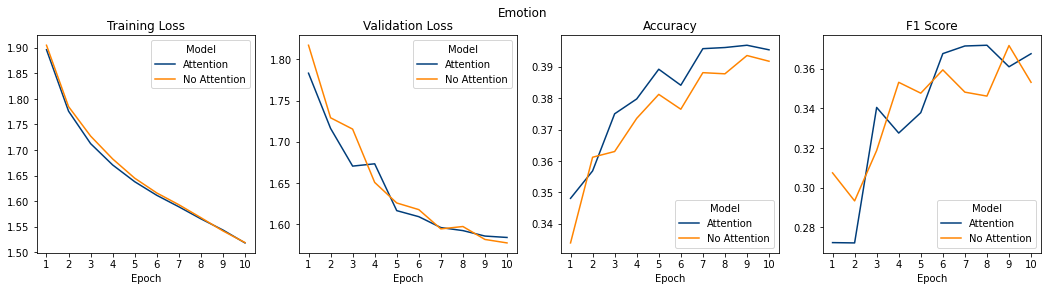

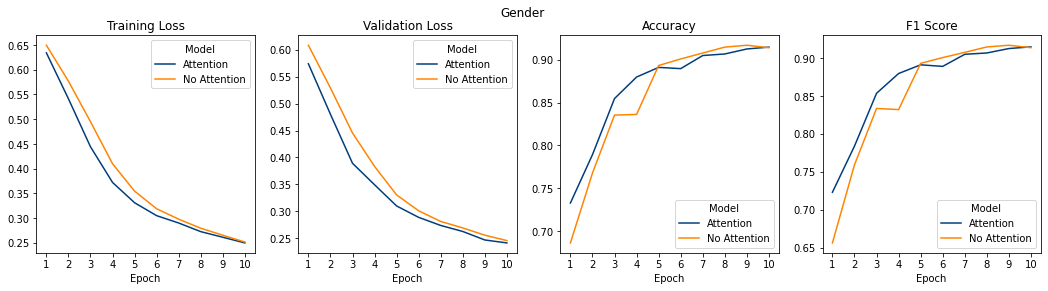

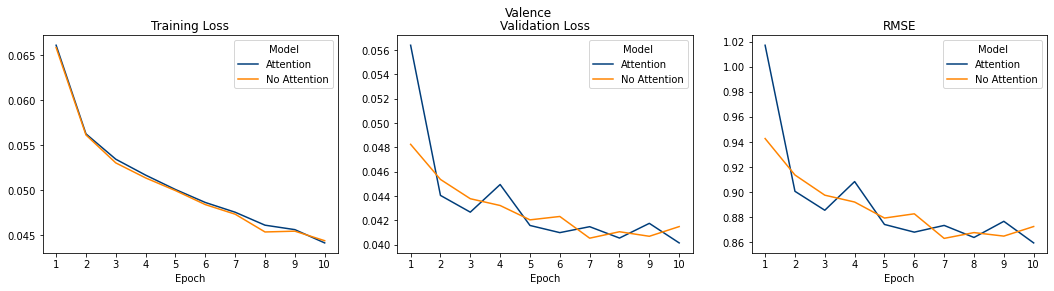

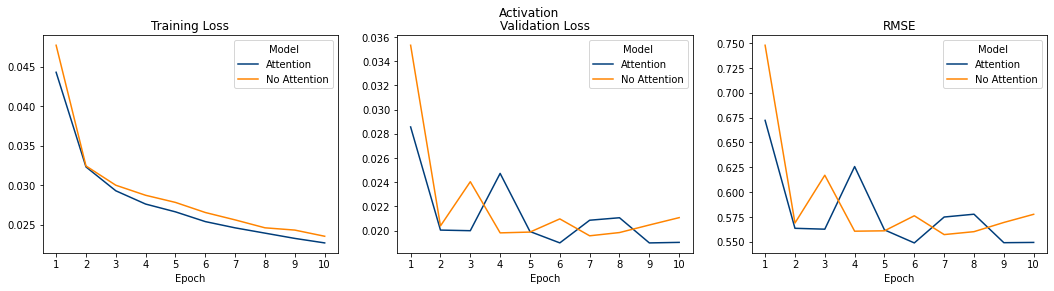

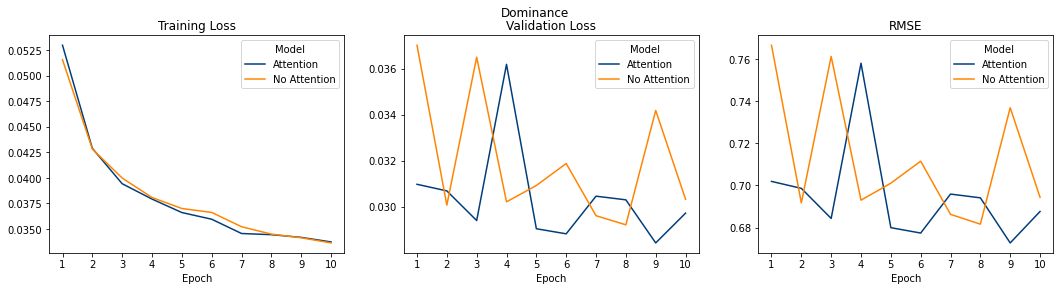

In [33]:
compare_complex(plotting_data['attention'], 'Attention', plotting_data['dropout'], 'No Attention', epochs)

#### Comparison (Attention and No Attention):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Attention | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |
| No Attention | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; | &#10006; |

> **Winner** - Attention

#### Weight Initialization:
- For convolutional and fully connected layers - 
> - The Kaiming He initialization avoids reducing or magnifying the magnitudes of input signals exponentially by statisfying the condition - $\frac{1}{2}n_l\text{Var}[w_l] = 1$.<br>
>>where 
>> - $n_l$ is the number of activations of layer $l$.
>> - $w_l$ are the weights of layer $l$.
> - This suggests to initialize the weights of layer $l$ with a zero-mean Gaussian distribution with a standard deviation of $\sqrt{\frac{2}{n_l}}$.<br>
> - This accounts for non-linear activations such as ReLU.
> - Biases is set to 0.
- For batch normalization layers - 
> - Weights are set to 1.<br>
> - Biases are set to 0.

In [34]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': False, 
    'attention': 0.0001, 'weight init': True
               }
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['weight init'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model No Init | Training Duration = 798.35 sec | Average Duration = 79.83 sec
Model Weight Init | Training Duration = 801.80 sec | Average Duration = 80.18 sec


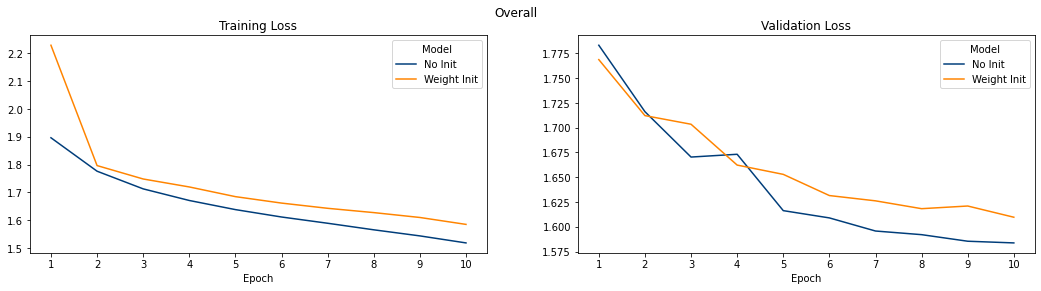

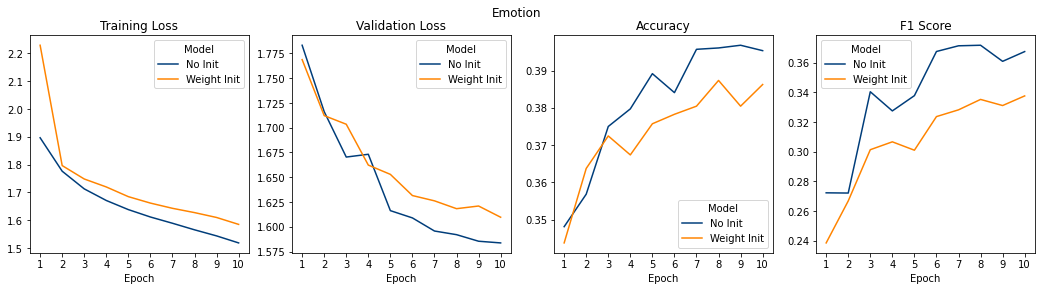

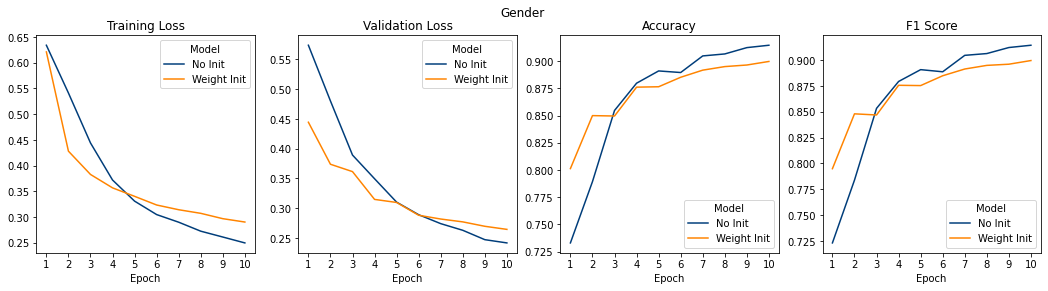

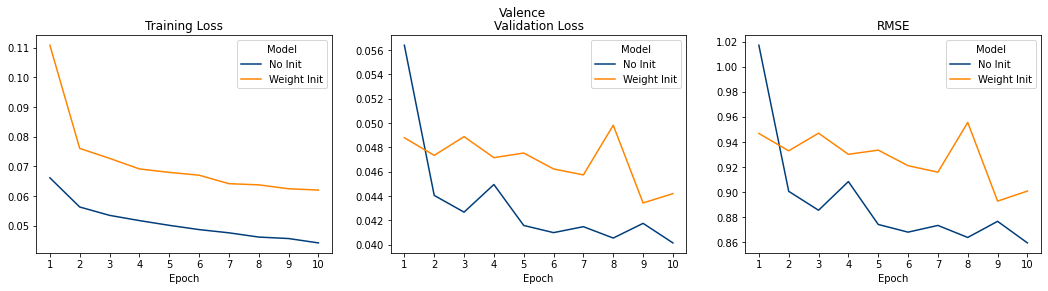

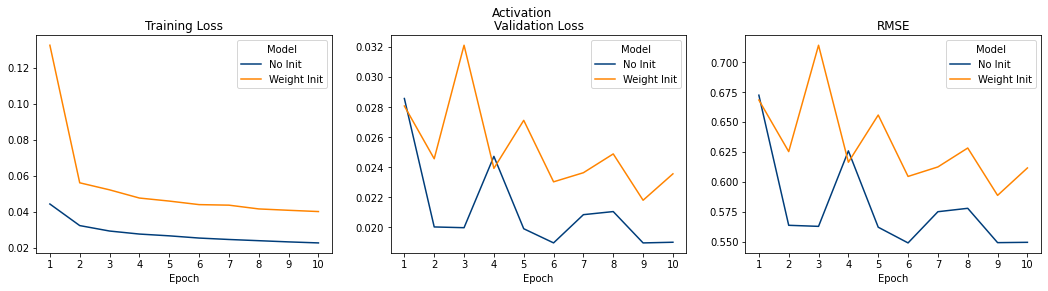

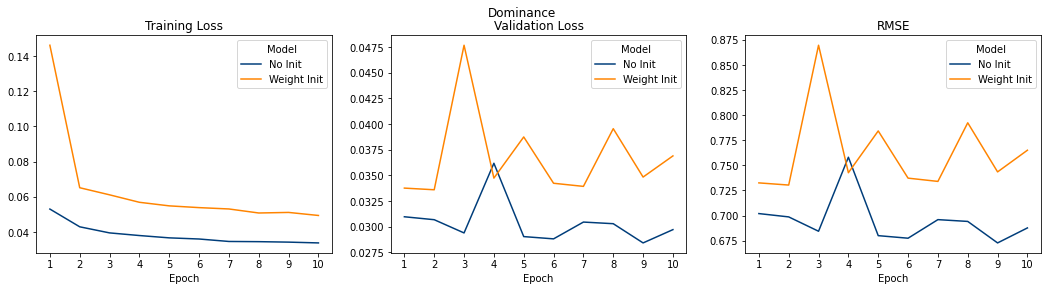

In [35]:
compare_complex(plotting_data['attention'], 'No Init', plotting_data['weight init'], 'Weight Init', epochs)

#### Comparison (Weight Init and No Init):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Weight Init | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; |
| No Init | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - No Init

<a id='section_three'></a>
## Section III
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- In this section, following changes are examined -
    - Optimization algorithm.
    - Momentum.
    - Weight decay or L2 regularization.
    - Learning rate decay.

- `layer_params` and `multitask_params` are constant for this section. 


| Layer Parameters | Multitask Parameters |
| :-: | :-: |
| Activation - ReLU | Loss Type - weighted param |
| Pooling - MaxPool | Loss Weights - None |
| Dropout - 0.5 | Task Layers - None | 
| Batch Norm - False | 
| Attention - 0.0001 |
| Weight Init - False |

In [37]:
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': None}

#### Optimization Algorithm (SGD vs RMSprop):

Stochastic Gradient Descent - 
- Implements gradient descent on one sample at a time.
- The path taken by the algorithm to reach the minima is usually noisier, but faster.

Root Mean Squared Propagation -
- It is an extension of gradient descent that uses a decaying average of partial gradients in the adaptation of the step size for each parameter. 
- The use of a decaying moving average allows the algorithm to forget early gradients and focus on the most recently observed partial gradients seen during the progress of the search.

> Both algorithm update over mini-batches.

In [38]:
optim_params = {'learning rate': 0.01, 'type': 'rmsprop', 'momentum': 0, 'weight decay': 0, 'scheduler': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['rmsprop'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model SGD | Training Duration = 798.35 sec | Average Duration = 79.83 sec
Model RMSprop | Training Duration = 776.59 sec | Average Duration = 77.66 sec


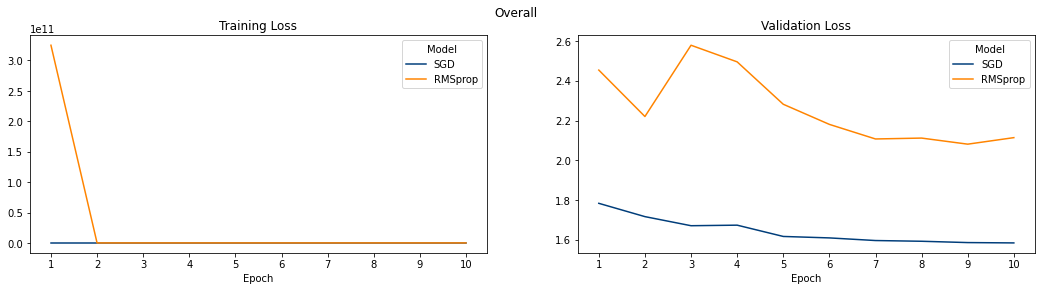

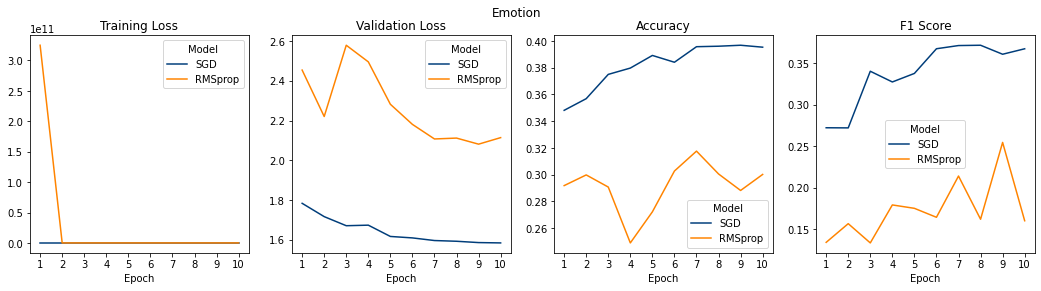

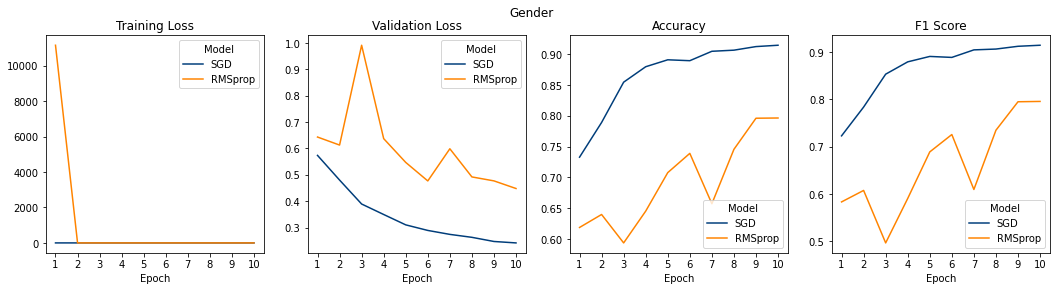

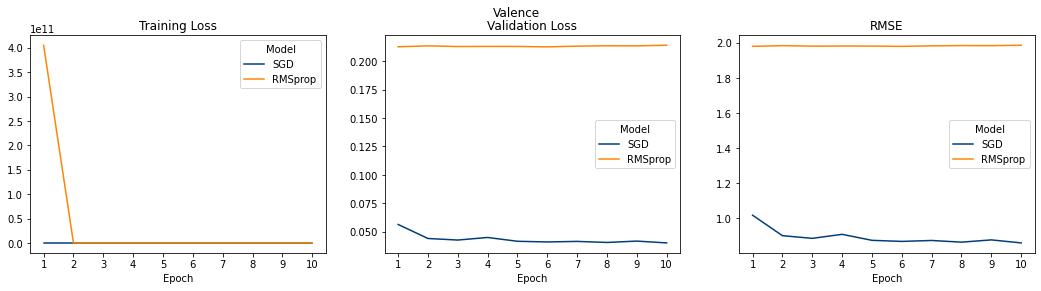

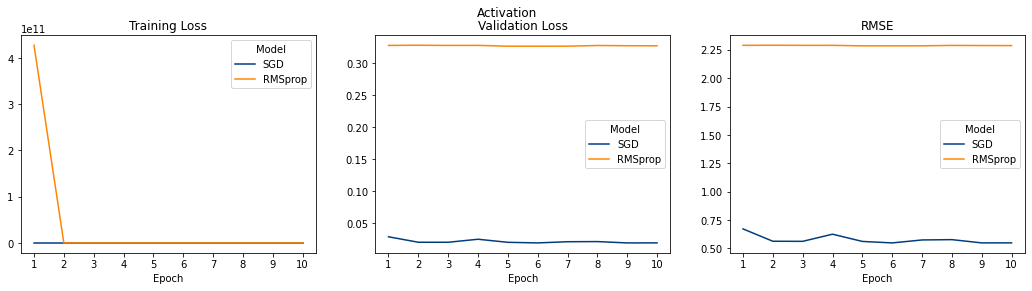

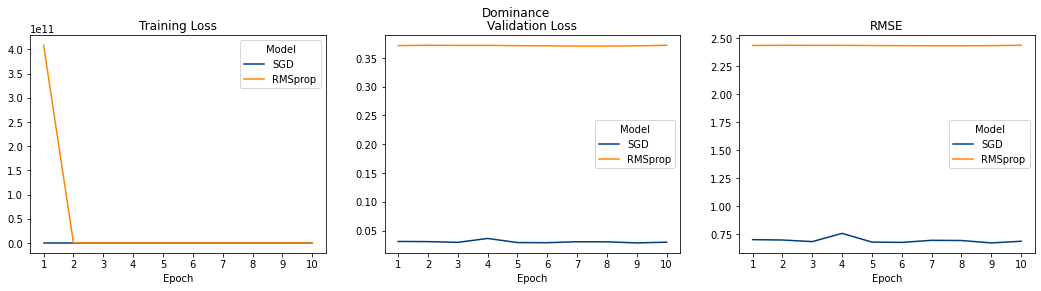

In [39]:
compare_complex(plotting_data['attention'], 'SGD', plotting_data['rmsprop'], 'RMSprop', epochs)

#### Comparison (RMSprop and SGD):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| RMSprop | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; |
| SGD | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - SGD

#### Momentum:
- With momentum, SGD remembers the update step at each iteration and determines the next update as a linear combination of the gradient and the previous update.
- The factor for the previous update, $\mu$ = **0.9**.

In [42]:
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0.9, 'weight decay': 0, 'scheduler': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['momentum'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model Momentum | Training Duration = 783.08 sec | Average Duration = 78.31 sec
Model No Momentum | Training Duration = 798.35 sec | Average Duration = 79.83 sec


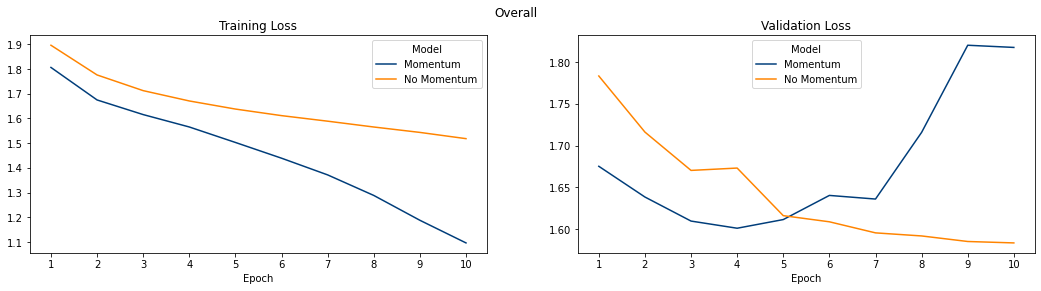

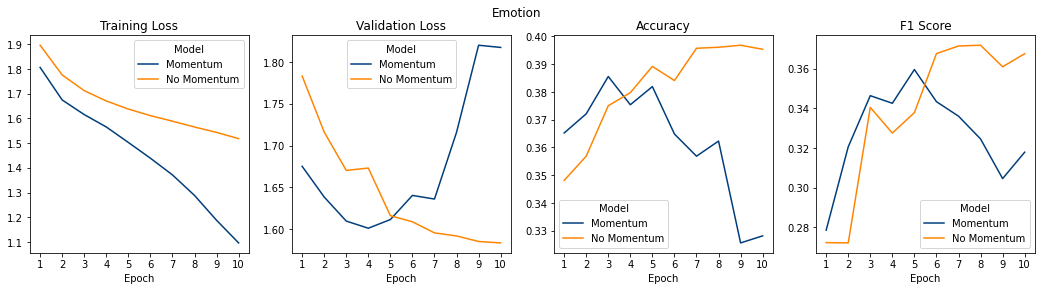

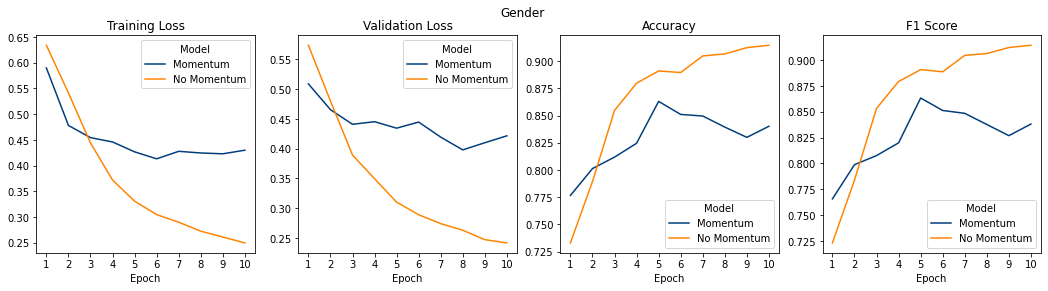

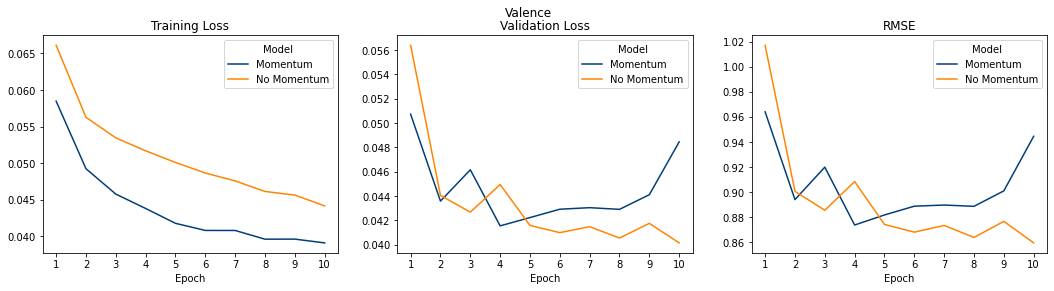

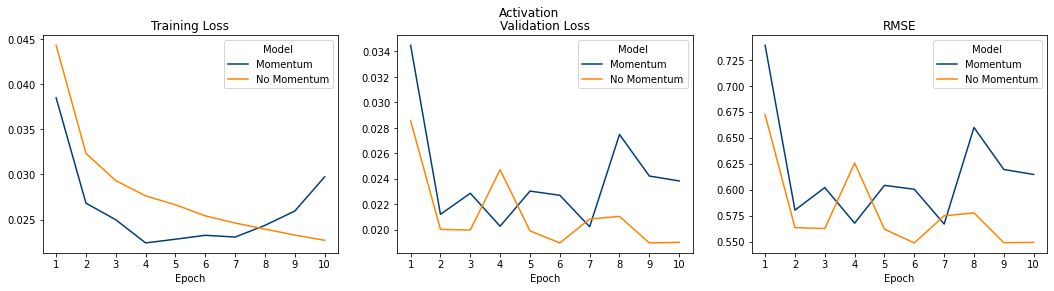

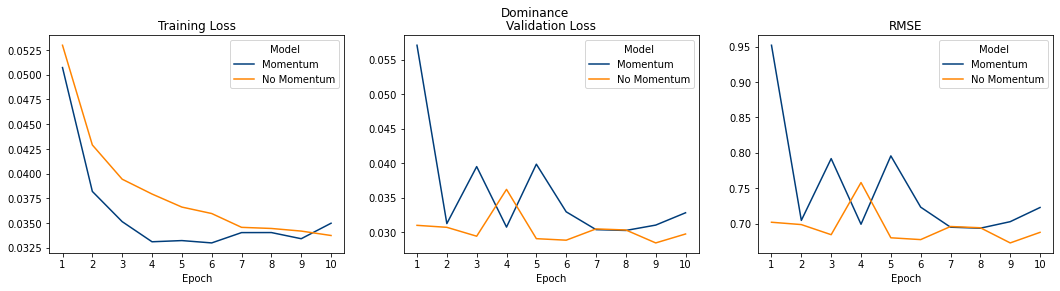

In [43]:
compare_complex(plotting_data['momentum'], 'Momentum', plotting_data['attention'], 'No Momentum', epochs)

#### Comparison (Momentum and No Momentum):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Momentum | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; |
| No Momentum | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - No Momentum

#### Weight Decay:
- L2 regularization adds a penalty to the loss function equal to the sum of the square of the magnitude of coefficients. 
- This is given by -
> $L_2 = \lambda * \sum_{i=0}^{N}W_i^2$<br>
> where 
> - $\lambda$ is set to **0.001**.

In [46]:
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0.01, 'scheduler': None}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['weight decay'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model WD | Training Duration = 782.48 sec | Average Duration = 78.25 sec
Model No WD | Training Duration = 798.35 sec | Average Duration = 79.83 sec


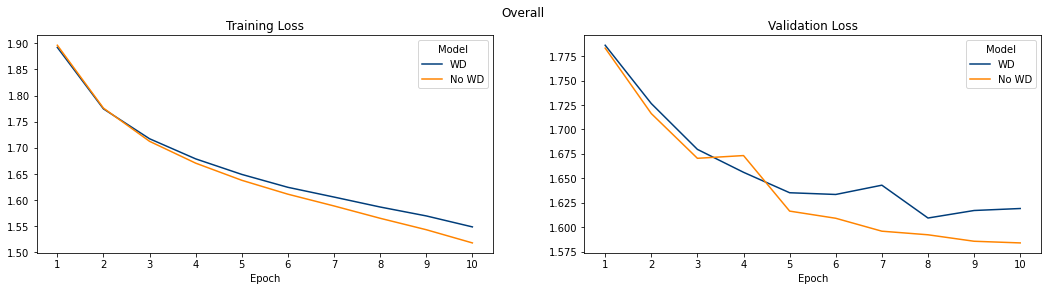

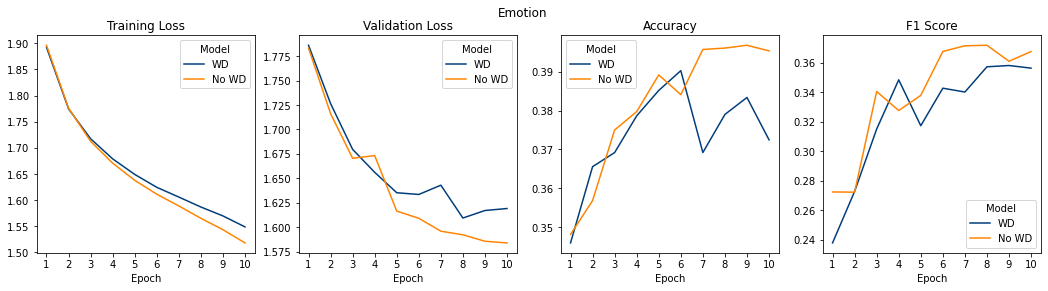

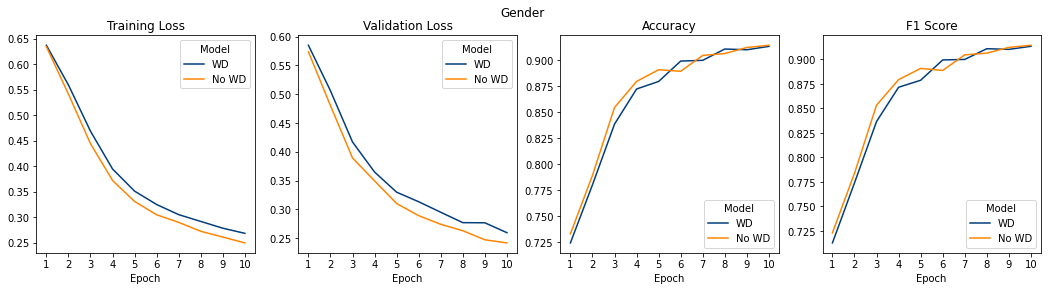

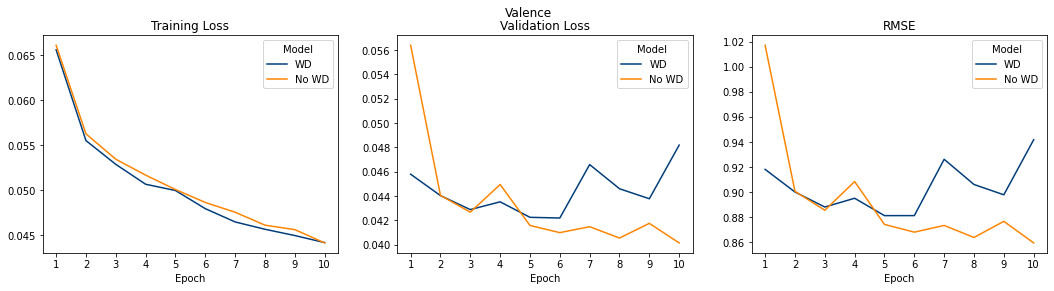

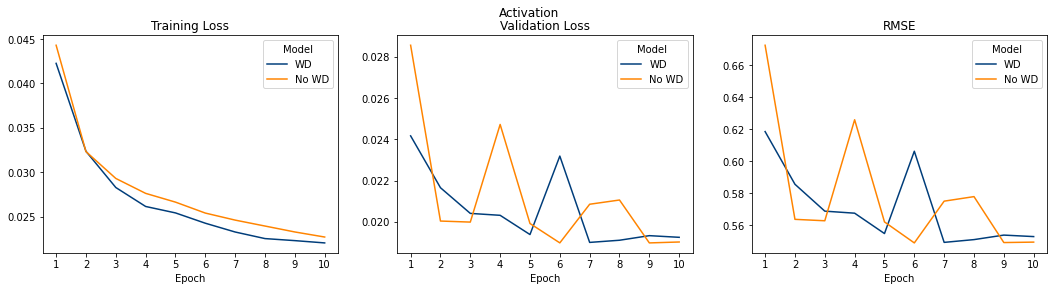

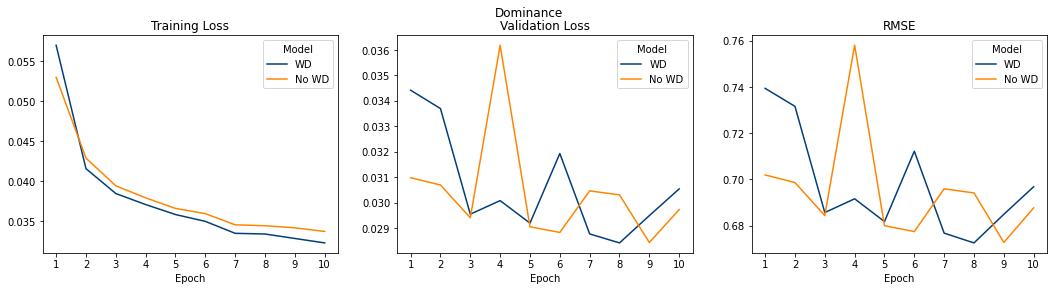

In [47]:
compare_complex(plotting_data['weight decay'], 'WD', plotting_data['attention'], 'No WD', epochs)

#### Comparison (WD and No WD):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| WD | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; | &#10004; |
| No WD | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - No WD

In [48]:
save_data(meta_root, plotting_data['attention'], 'Plot')

#### Learning Rate Decay:
Training for **20 epochs** to get an idea of learning curves.

In [51]:
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': None}
other_params['epochs'] = 20

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['20 epochs'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 20', layout=Layout(width='500px'), max=20, style=ProgressStyle(d…

Total Epochs = 20
Model 20 Epochs | Training Duration = 1499.82 sec | Average Duration = 74.99 sec


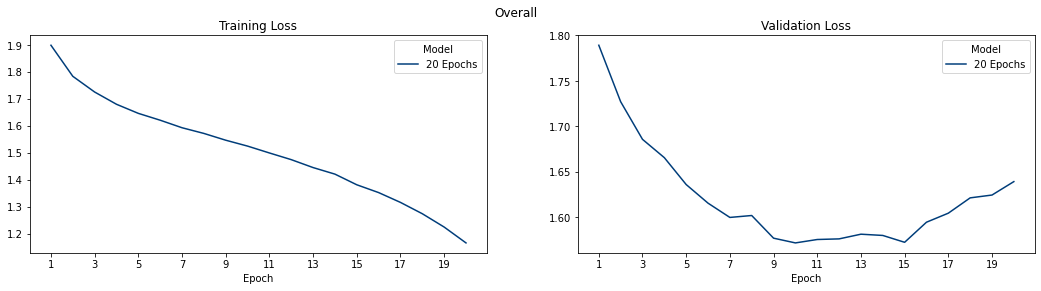

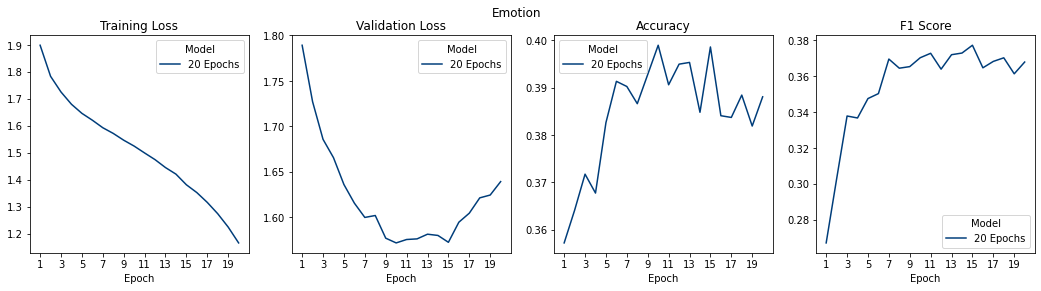

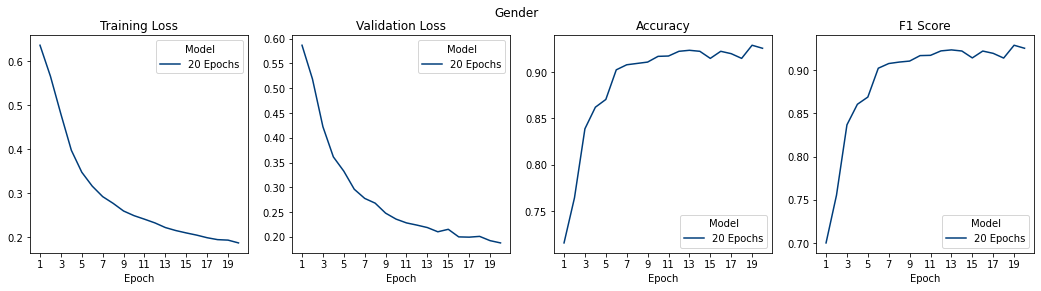

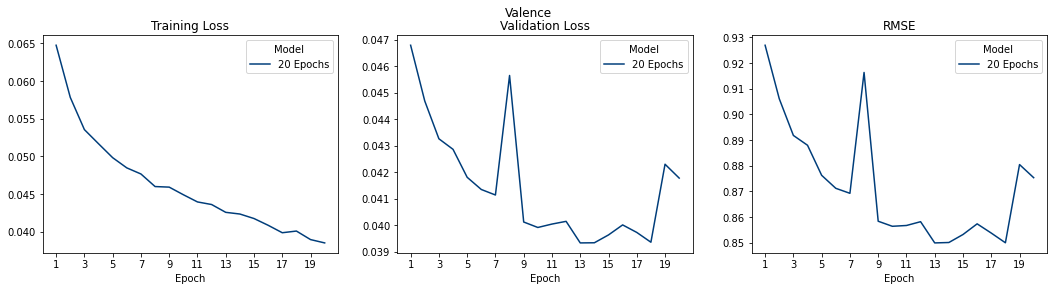

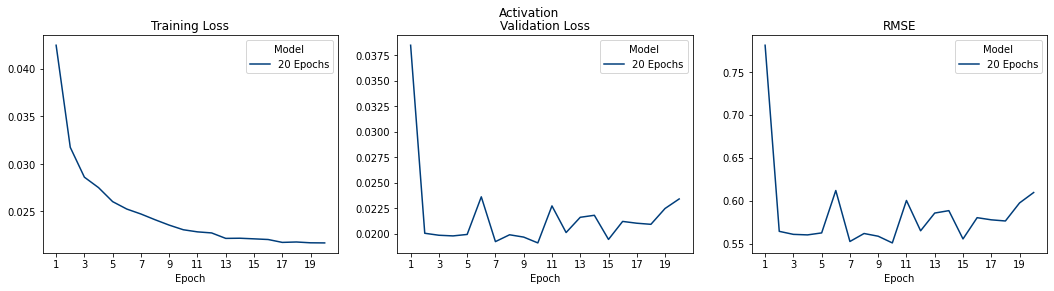

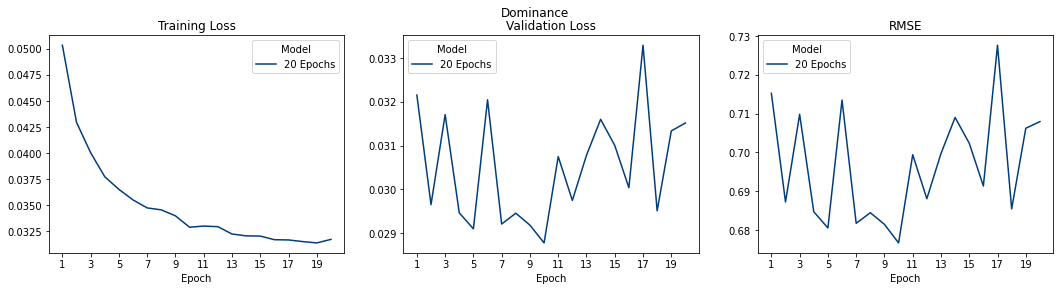

In [54]:
plot_complex(plotting_data['20 epochs'], '20 Epochs', epochs = 20)

Using `MultiStepLR` -
> It decays the learning rate by gamma once the number of epoch reaches one of the milestones.<br>
> `gamma` - set to **0.1**.<br>
> `milestones` - set to **[10]**.

In [55]:
scheduler_params = ([10], 0.1)
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': scheduler_params}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['scheduler'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 20', layout=Layout(width='500px'), max=20, style=ProgressStyle(d…

Total Epochs = 20
Model No Decay | Training Duration = 1499.82 sec | Average Duration = 74.99 sec
Model Decay | Training Duration = 1532.96 sec | Average Duration = 76.65 sec


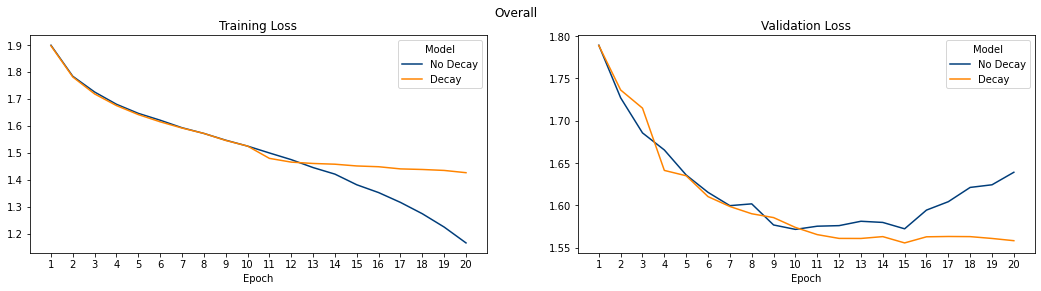

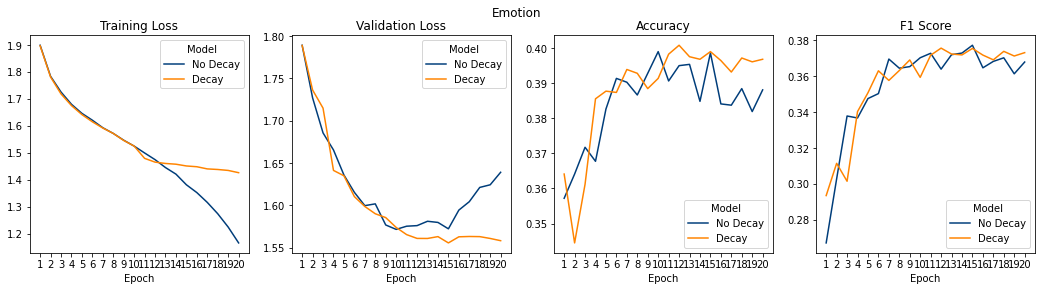

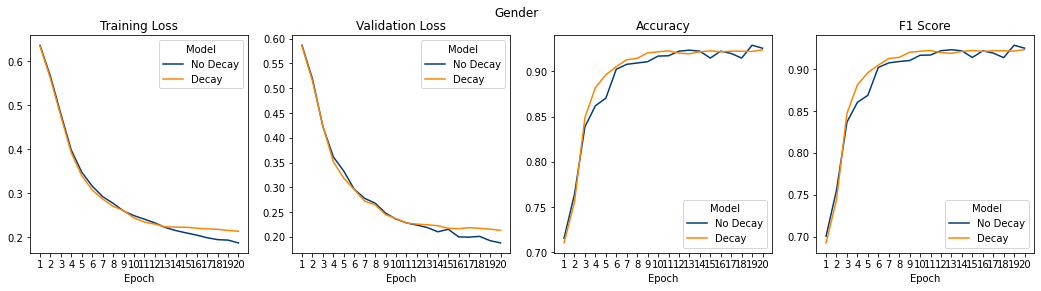

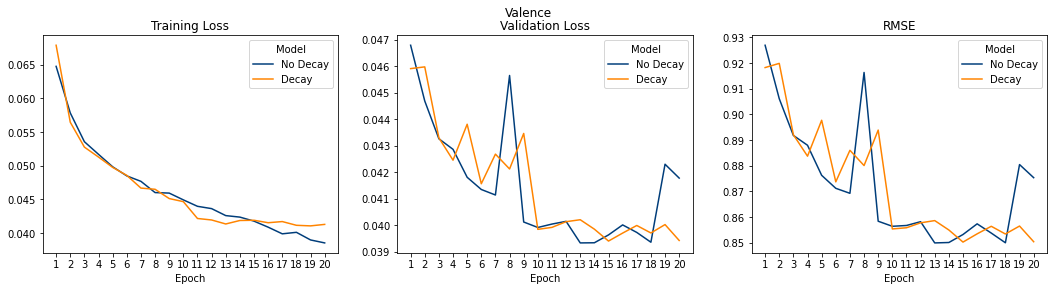

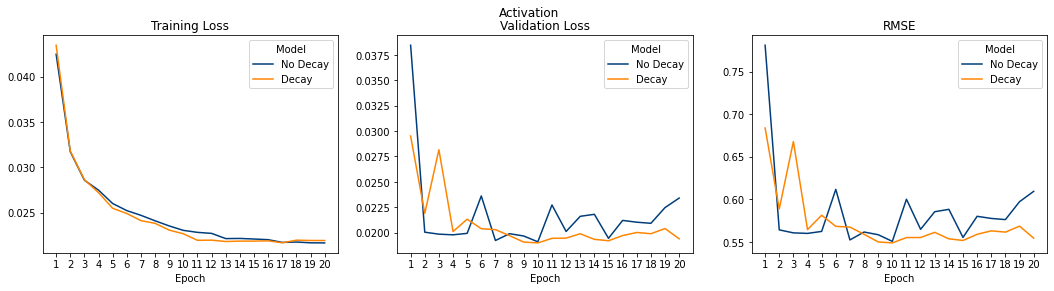

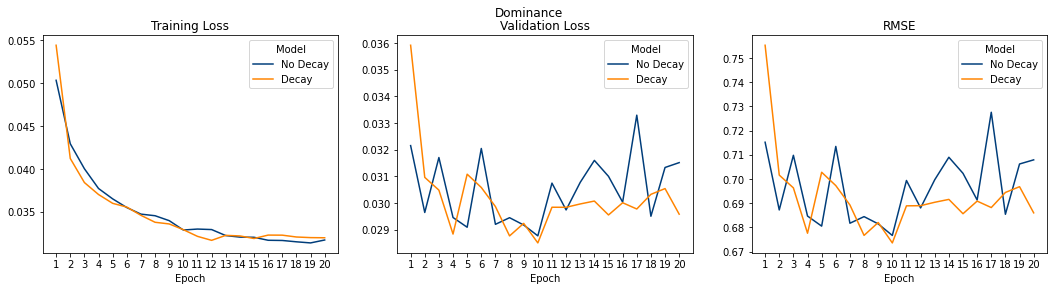

In [57]:
compare_complex(plotting_data['20 epochs'], 'No Decay', plotting_data['scheduler'], 'Decay', epochs = 20)

#### Comparison (Decay and No Decay):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Decay | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |
| No Decay | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; |

> **Winner** - Decay

<a id='final'></a>
## Final Values
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

The selected values are -
- `scaling_type` - 'min-max'

- Other parameters - 

| Layer Parameters | Optimizer Parameters | Multitask Parameters |
| :-: | :-: | :-: |
| Activation - ReLU | Learning Rate - 0.01 | Loss Type - weighted param |
| Pooling - MaxPool | Type - SGD | Loss Weights - None |
| Dropout - 0.5 | Momentum - 0 | Task Layers - None | 
| Batch Norm - False | Weight Decay - 0 |
| Attention - 0.0001 | Scheduler - ([10], 0.1) |
| Weight Init - False |

<a id='save_file'></a>
## Save File
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Saving the scaling type in `Statistics` and the improved model in `Development Data`.

In [71]:
stats['scaling type'] = other_params['scaling type']
save_data(meta_root, stats, 'Statistics')

In [ ]:
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta'